In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models import resnet18 , mobilenet_v2
from __future__ import print_function
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
from torchvision.ops.boxes import box_area
import torch.nn.functional as F
import torch
import cv2
import os
import re
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as FT

Deniz Arda Dulkadir 2220765014

[Drive Link](https://drive.google.com/drive/folders/1lFbdsEjFDoIVYIFqd2W514YNSxRle0nt?usp=sharing)

In [2]:
class SimpleSinePE(nn.Module):
    def __init__(self, d_model=256):
        super().__init__()
        self.d_model = d_model
        
    def forward(self, x):
        B, C, H, W = x.shape
        device = x.device
        # Change chanels
        y_embed = torch.arange(H, device=device).float().unsqueeze(1).repeat(1, W)
        x_embed = torch.arange(W, device=device).float().unsqueeze(0).repeat(H, 1)
        
        y_embed = y_embed / (H + 1e-6) * 2 * math.pi
        x_embed = x_embed / (W + 1e-6) * 2 * math.pi
        
        dim_t = torch.arange(self.d_model // 4, device=device).float()
        dim_t = 10000 ** (2 * (dim_t // 2) / (self.d_model // 2))
        
        pos_x = x_embed.unsqueeze(-1) / dim_t
        pos_y = y_embed.unsqueeze(-1) / dim_t
        # Pos encodeing with sin cos matrix formulas
        pos_x = torch.stack((pos_x.sin(), pos_x.cos()), dim=3).flatten(2)
        pos_y = torch.stack((pos_y.sin(), pos_y.cos()), dim=3).flatten(2)
        
        pos = torch.cat((pos_y, pos_x), dim=2).permute(2, 0, 1).unsqueeze(0).repeat(B, 1, 1, 1)
        # Encoded pos
        return pos

In [3]:
class DETR(nn.Module):
    def __init__(self,d_model=256,n_classes=2, n_layers=2, n_heads=8,n_queries=50, backbone_name="resnet"):
        super().__init__()
        # Backbone
        if backbone_name == "resnet":
            m = resnet18(pretrained=True)
            self.backbone = nn.Sequential(*list(m.children())[:-2]) 
            input_channels = 512
        else:
            m = mobilenet_v2(pretrained=True)
            self.backbone = m.features
            input_channels = 1280
        # 1x1 conv
        self.conv1x1 = nn.Conv2d(input_channels, d_model, kernel_size=1)
        # Pos encoding
        self.position_embedding = SimpleSinePE(d_model=d_model)
        # Encoder decoder (transformer)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads), 
            num_layers=n_layers
        )

        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads), 
            num_layers=n_layers
        )
        # Specialized queries
        self.queries = nn.Parameter(torch.rand(n_queries, d_model))
        # No class or class and bounding box 4 cordinates
        self.class_head = nn.Linear(d_model, n_classes)
        self.bbox_head = nn.Linear(d_model, 4)

    def forward(self, x):
        
        x = self.backbone(x)
        
        h = self.conv1x1(x) 
        
        pos = self.position_embedding(h)
        
        # [Seq_Len, Batch, d_model]
        bs, c, H, W = h.shape
        h = h.flatten(2).permute(2, 0, 1)    
        pos = pos.flatten(2).permute(2, 0, 1) 
        #Using the encoded pos and hfrom conv
        memory = self.transformer_encoder(h + pos)
        
        query_embed = self.queries.unsqueeze(1).repeat(1, bs, 1) # [n_queries, Batch, d_model]
        
        out_decoder = self.transformer_decoder(query_embed, memory)
        
        out_decoder = out_decoder.permute(1, 0, 2) # [Batch, n_queries, d_model]
        # Last prediction
        class_pred = self.class_head(out_decoder)
        bbox_pred = self.bbox_head(out_decoder).sigmoid() 
        
        return class_pred, bbox_pred

In [4]:
class PedestrianDataset(Dataset):
    def __init__(self, image_files, image_dir, label_dir, mode='val', jit=False , flip = False):
        self.image_files = image_files
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.mode = mode
        self.jit = jit
        self.flip = flip
        # Normalization numbers come from result from google 
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Color Jitter settings defult i have seen
        self.jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)

    def __len__(self):
        # Traing has 4 times data from augmentations 
        if self.mode == 'train':
            return len(self.image_files) * 4
        else:
            return len(self.image_files)

    def __getitem__(self, idx):
        # Determine which image and which augmentation to use
        real_idx = idx % len(self.image_files)
        
        if self.mode == 'train':
            # Original, Flip, Jitter, Flip + Jitter total of 4 images per image
            aug_type = idx // len(self.image_files) 
        else:
            aug_type = 0 # No augmentation for validation

        # Load
        filename = self.image_files[real_idx]
        img_path = os.path.join(self.image_dir, filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        orig_h, orig_w = image.shape[:2]
        
        # Resize to 412
        target_h, target_w = 512, 512
        image = cv2.resize(image, (target_w, target_h))
        
        # 3. Load Boxes
        label_filename = os.path.splitext(filename)[0] + ".txt"
        label_path = os.path.join(self.label_dir, label_filename)
        
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    if "Bounding box for object" in line:
                        # Using regex find the line that gives box
                        match = re.search(r'\(\s*(\d+)\s*,\s*(\d+)\s*\)\s*-\s*\(\s*(\d+)\s*,\s*(\d+)\s*\)', line)
                        if match:
                            # Bounding cordinates
                            xmin, ymin = float(match.group(1)), float(match.group(2))
                            xmax, ymax = float(match.group(3)), float(match.group(4))
                            
                            # Scale boxes to 512x512
                            xmin = xmin * (target_w / orig_w)
                            xmax = xmax * (target_w / orig_w)
                            ymin = ymin * (target_h / orig_h)
                            ymax = ymax * (target_h / orig_h)
                            boxes.append([xmin, ymin, xmax, ymax])

        # Convert to Tensor/PIL for augmentation
        image_pil = FT.to_pil_image(image)
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        
        # Types 2 and 3: Apply Color Jitter
        if self.jit and (aug_type == 2 or aug_type == 3):
            image_pil = self.jitter(image_pil)
            
        # Types 1 and 3: Apply Horizontal Flip
        if self.flip and (aug_type == 1 or aug_type == 3):
            image_pil = FT.hflip(image_pil)
            
            if len(boxes) > 0:
                # New xmin = width - old_xmax
                new_xmin = target_w - boxes[:, 2]
                new_xmax = target_w - boxes[:, 0]
                boxes[:, 0] = new_xmin
                boxes[:, 2] = new_xmax

        # 5. Final Normalize & Format
        image_tensor = self.normalize(image_pil)
        
        # Convert boxes to CXCYWH (centered) and normalize 0-1
        if len(boxes) > 0:
            boxes_cxcywh = torch.zeros_like(boxes)
            boxes_cxcywh[:, 0] = (boxes[:, 0] + boxes[:, 2]) / 2 / target_w
            boxes_cxcywh[:, 1] = (boxes[:, 1] + boxes[:, 3]) / 2 / target_h
            boxes_cxcywh[:, 2] = (boxes[:, 2] - boxes[:, 0]) / target_w
            boxes_cxcywh[:, 3] = (boxes[:, 3] - boxes[:, 1]) / target_h
            boxes_cxcywh = boxes_cxcywh.clamp(0, 1)
            labels = torch.zeros((len(boxes),), dtype=torch.int64)

        else:
            boxes_cxcywh = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes_cxcywh,
            "labels": labels
        }
        return image_tensor, target

In [5]:
def collate_fn(batch):
    # Helper func
    return tuple(zip(*batch))

# These are from the original papers implemtations
def box_cxcywh_to_xyxy(x):
    # Func to change the corinates to centered
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

def box_iou(boxes1, boxes2):
    # Finding the union and itersection of union
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  

    wh = (rb - lt).clamp(min=0)  
    inter = wh[:, :, 0] * wh[:, :, 1]  

    union = area1[:, None] + area2 - inter

    iou = inter / union
    return iou, union

def generalized_box_iou(boxes1, boxes2):
    # Using the iou get the area and return generalize verison of iou
    assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
    assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
    
    iou, union = box_iou(boxes1, boxes2)

    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)  
    area = wh[:, :, 0] * wh[:, :, 1]

    return iou - (area - union) / area

In [6]:
import torch.nn as nn
from scipy.optimize import linear_sum_assignment

class HungarianMatcher(nn.Module):
    def __init__(self, cost_class=1, cost_bbox=5, cost_giou=2):
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        bs, num_queries = outputs[0].shape[:2]

        # We flatten the batch dimension to compute costs for all samples at once
        out_prob = outputs[0].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs[1].flatten(0, 1)  # [batch_size * num_queries, 4]

        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Take the maximum prob but use negaitive for min function later
        cost_class = -out_prob[:, tgt_ids]

        # 2. L1 Box Cost
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        # 3. GIoU Cost
        cost_giou = -generalized_box_iou(
            box_cxcywh_to_xyxy(out_bbox), 
            box_cxcywh_to_xyxy(tgt_bbox)
        )

        # Final Cost Matrix using the formula
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        
        # Perform Hungarian Matching linear_sum_assignment solving
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices] 

In [7]:
class SetCriterion(nn.Module):
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        self.empty_weight = torch.ones(self.num_classes + 1)
        self.empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight_tensor', self.empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight_tensor)
        losses = {'loss_ce': loss_ce}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(generalized_box_iou(
            box_cxcywh_to_xyxy(src_boxes),
            box_cxcywh_to_xyxy(target_boxes)))
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def _get_src_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'boxes': self.loss_boxes,
        }
        assert loss in loss_map, f'do not know {loss} loss'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        # Convert tuple output to dictionary for easier handling
        outputs_dict = {'pred_logits': outputs[0], 'pred_boxes': outputs[1]}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs_dict.values())).device)
        # (In distributed training, you would average this across GPUs. For single GPU, just clamp > 1)
        num_boxes = torch.clamp(num_boxes, min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs_dict, targets, indices, num_boxes))
            
        # Combine into final weighted loss
        final_loss = sum(losses[k] * self.weight_dict[k] for k in losses.keys() if k in self.weight_dict)
        
        return final_loss, losses

In [8]:
def train_one_epoch(model, loader, optimizer, epoch, scaler):
    model.train()
    running_loss = 0.0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Train]")
    
    for r_img, targets in loop:
        r_img = torch.stack(r_img).to(device)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad(set_to_none=True)
        # Faster
        with torch.amp.autocast('cuda'): 
            # Predict get loss
            pred_class, pred_box = model(r_img)
            outputs = (pred_class, pred_box)
            loss, _ = criterion(outputs, targets)
            
        scaler.scale(loss).backward()
        
        # Gradient Clipping for stab
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        
    return running_loss / len(loader)

def validate(model, loader):
    # Eval mode
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for r_img, targets in loader:
            r_img = [img.to(device) for img in r_img]
            r_img = torch.stack(r_img)
            
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            with torch.cuda.amp.autocast():
                pred_class, pred_box = model(r_img)
                
                # Pack outputs for criterion
                outputs = (pred_class, pred_box)
                
                # Calculate Loss
                loss, _ = criterion(outputs, targets)
                
            running_loss += loss.item()
            
    return running_loss / len(loader)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
losses = ['labels', 'boxes']
# These are the authors defolut numbers
matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
# Using our own criterion matcher and defoult weight dict
# Create a criterion eos if how bold predictions it can make
criterion = SetCriterion(num_classes=1, matcher=matcher, weight_dict=weight_dict, eos_coef=0.1, losses=losses)
criterion = criterion.to(device)

In [10]:
def load_model(checkpoint_path,n_layers=2,n_heads=8,n_queries=50, backbone_name="resnet", device=None):
    # Helper for loading models after saving them
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DETR(backbone_name=backbone_name, n_queries=n_queries,n_layers=n_layers,n_heads=n_heads)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint, strict=True)
    model.to(device)
    
    model.eval() 
    
    for param in model.parameters():
        param.requires_grad = False
        
    return model

In [11]:
def compute_map(detections, annotations, iou_threshold=0.5):
    scores = []
    for det, ann in zip(detections, annotations):
        if len(ann) == 0:
            continue
        if len(det) == 0:
            scores.append(0.0)
            continue
            
        # Ensure shapes are [N, 4] even if there is only 1 box
        if det.dim() == 1: det = det.unsqueeze(0)
        if ann.dim() == 1: ann = ann.unsqueeze(0)
        
        # Compute all matrixes at once
        iou_matrix = box_iou(det, ann)[0]
        
        tp = 0
        fp = 0
        used = torch.zeros(len(ann), dtype=torch.bool)
        
        # 3. Greedy Matching
        for i in range(len(det)):
            best_iou = 0.0
            best_gt_idx = -1
            
            # Find the brst greedy match
            for j in range(len(ann)):
                if not used[j]: 
                    if iou_matrix[i, j] > best_iou:
                        best_iou = iou_matrix[i, j]
                        best_gt_idx = j
            
            # Check threshold
            if best_iou >= iou_threshold:
                tp += 1
                used[best_gt_idx] = True # Mark GT as used
            else:
                fp += 1
        
        # Get all scores
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / len(ann)
        
        if (precision + recall) > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0
        scores.append(f1)

    return np.mean(scores) if len(scores) > 0 else 0

In [12]:
def evaluate_and_get_predictions(model, loader, device, threshold=0.5):
    # Get prediction scores
    model.eval()
    
    all_pred_boxes = [] 
    all_gt_boxes = []   
    
    with torch.no_grad():
        for r_img, targets in tqdm(loader, desc="Evaluating"):
            r_img = [img.to(device) for img in r_img]
            r_img = torch.stack(r_img)
            
            #Predict
            with torch.amp.autocast('cuda'):
                pred_logits, pred_boxes = model(r_img)
            
            for i in range(len(targets)):
                
                # Chage the boxes to useful corinates
                gt_box = targets[i]['boxes'].cpu() 
                gt_box_xyxy = box_cxcywh_to_xyxy(gt_box)
                all_gt_boxes.append(gt_box_xyxy)
                
                p_box = pred_boxes[i].cpu()     
                p_logits = pred_logits[i].cpu() 
                # Get probs of every box
                prob = p_logits.softmax(dim=-1) 
                scores = prob[:, 0] 
                
                # Skip threshold of 0.5
                keep_indices = scores > threshold
                
                filtered_boxes = p_box[keep_indices]
                
                # Return to normal cordinates
                filtered_boxes_xyxy = box_cxcywh_to_xyxy(filtered_boxes)
                
                all_pred_boxes.append(filtered_boxes_xyxy)

    return all_pred_boxes, all_gt_boxes

In [13]:
# Helper to reverse the ImageNet normalization
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

# Same std and mean i used since normalized data seem 
# Strange to normal eyes
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [14]:
def visualize_results(model, loader, device, threshold=0.1, n_images=4):
    model.eval()
    images_shown = 0
    
    plt.figure(figsize=(20, 5))
    
    with torch.no_grad():
        for r_img, targets in loader:
            r_img = [img.to(device) for img in r_img]
            r_img_stack = torch.stack(r_img)
            
            pred_logits, pred_boxes = model(r_img_stack)
            # Same start for getting images boxes
            for i in range(len(r_img)):
                if images_shown >= n_images: break
                
                # Get Image for plotting (C, H, W) -> (H, W, C)
                img_tensor = r_img[i].cpu().clone() 

                # Un-normalize
                img_tensor = unorm(img_tensor)

                img_tensor = torch.clamp(img_tensor, 0, 1)

                img_np = img_tensor.permute(1, 2, 0).numpy()
                img_np = np.ascontiguousarray(img_np)
                
                # Get Predictions
                prob = pred_logits[i].softmax(-1)
                scores = prob[:, 0] 
                keep = scores > threshold
                
                boxes = pred_boxes[i][keep].cpu() # cx, cy, w, h
                
                # Convert to pixel coords for cv2
                h, w, _ = img_np.shape
                for box in boxes:
                    cx, cy, bw, bh = box
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)
                    
                    # Box pred red for pred
                    cv2.rectangle(img_np, (x1, y1), (x2, y2), (255, 0, 0), 2)
                
                # Green for gt
                gt_boxes = targets[i]['boxes'].cpu()
                for box in gt_boxes:
                    cx, cy, bw, bh = box
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)
                    cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                plt.subplot(1, n_images, images_shown+1)
                plt.imshow(img_np)
                plt.title(f"Red: Pred | Green: GT")
                plt.axis("off")
                
                images_shown += 1
            
            if images_shown >= n_images: break
    plt.show()

In [15]:
def plot_training_curves(history):
    # Just line graph for history val train loss
    train_losses = []
    test_losses= []
    for record in history:
        train_losses.append(record[0])
        test_losses.append(record[1])

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()


In [16]:
# Read and get box cordinates and images
train_data = []
with open("train.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        train_data.append(line.strip())
test_data = []
with open("test.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        test_data.append(line.strip())
val_data = []
with open("val.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        val_data.append(line.strip())
imagepaths = 'C:\\kod\\CV detection\\PennFudanPed\\PNGImages'
labelpaths = 'C:\\kod\\CV detection\\PennFudanPed\\Annotation'



In [17]:
# For start no augmentation
trainset=PedestrianDataset(train_data,imagepaths,labelpaths,mode="train",jit=False,flip=False)
valset = PedestrianDataset(val_data,imagepaths,labelpaths,mode="val")
testset = PedestrianDataset(test_data,imagepaths,labelpaths,mode="val")
# 8 For fast process and low data count
BATCH_SIZE = 8

# Higher batch for traing for generalization
train_loader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE*2, 
    shuffle=True, 
    pin_memory=True,
    collate_fn=collate_fn  
)

val_loader = DataLoader(
    valset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    collate_fn=collate_fn  
)

test_loader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn  
)

I start with n_layyers 2, n_heads 8 , n_queries = 50 and resnet for base model 

In [18]:
# Base model with no change
model_1 = DETR().to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')

print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_non_augment_base.pth")
        print("✓ Saved best model")

print("Training Complete.")

c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\kod\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\deniz\AppData\Local\Temp\ipykernel_26040\945761902.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is dep

Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=2.62]
C:\Users\deniz\AppData\Local\Temp\ipykernel_26040\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 2.9877 | Val Loss: 2.3897
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.16it/s, loss=2.24]


Epoch 2/30 | Train Loss: 2.2388 | Val Loss: 2.3654
✓ Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.12it/s, loss=1.99]


Epoch 3/30 | Train Loss: 2.1871 | Val Loss: 2.3916


Epoch 4 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.11it/s, loss=2.37]


Epoch 4/30 | Train Loss: 2.3543 | Val Loss: 2.4537


Epoch 5 [Train]: 100%|██████████| 30/30 [00:07<00:00,  3.81it/s, loss=2.27]


Epoch 5/30 | Train Loss: 2.0645 | Val Loss: 2.1670
✓ Saved best model


Epoch 6 [Train]: 100%|██████████| 30/30 [00:07<00:00,  3.93it/s, loss=2.17]


Epoch 6/30 | Train Loss: 2.1556 | Val Loss: 2.1141
✓ Saved best model


Epoch 7 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.03it/s, loss=2.33]


Epoch 7/30 | Train Loss: 2.1559 | Val Loss: 2.4723


Epoch 8 [Train]: 100%|██████████| 30/30 [00:07<00:00,  3.93it/s, loss=2.46]


Epoch 8/30 | Train Loss: 1.9639 | Val Loss: 2.0479
✓ Saved best model


Epoch 9 [Train]: 100%|██████████| 30/30 [00:08<00:00,  3.73it/s, loss=1.97]


Epoch 9/30 | Train Loss: 1.9428 | Val Loss: 2.1068


Epoch 10 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=1.96]


Epoch 10/30 | Train Loss: 1.9249 | Val Loss: 2.3273


Epoch 11 [Train]: 100%|██████████| 30/30 [00:09<00:00,  3.12it/s, loss=2.01]


Epoch 11/30 | Train Loss: 1.9703 | Val Loss: 2.2578


Epoch 12 [Train]: 100%|██████████| 30/30 [00:07<00:00,  3.99it/s, loss=1.82]


Epoch 12/30 | Train Loss: 1.9256 | Val Loss: 2.2556


Epoch 13 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.08it/s, loss=2.11]


Epoch 13/30 | Train Loss: 1.9643 | Val Loss: 2.2888


Epoch 14 [Train]: 100%|██████████| 30/30 [00:07<00:00,  3.96it/s, loss=2.22]


Epoch 14/30 | Train Loss: 1.8530 | Val Loss: 2.2388


Epoch 15 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.06it/s, loss=1.97]


Epoch 15/30 | Train Loss: 1.7775 | Val Loss: 2.2143


Epoch 16 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.17it/s, loss=1.89]


Epoch 16/30 | Train Loss: 1.8484 | Val Loss: 2.1063


Epoch 17 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.12it/s, loss=1.81]


Epoch 17/30 | Train Loss: 1.7836 | Val Loss: 2.1575


Epoch 18 [Train]: 100%|██████████| 30/30 [00:07<00:00,  3.98it/s, loss=1.82]


Epoch 18/30 | Train Loss: 1.7304 | Val Loss: 2.1487


Epoch 19 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.15it/s, loss=2.02]


Epoch 19/30 | Train Loss: 1.7441 | Val Loss: 2.0964


Epoch 20 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.11it/s, loss=1.35]


Epoch 20/30 | Train Loss: 1.6348 | Val Loss: 2.0758


Epoch 21 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.18it/s, loss=1.58]


Epoch 21/30 | Train Loss: 1.6434 | Val Loss: 2.0455
✓ Saved best model


Epoch 22 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.09it/s, loss=1.74]


Epoch 22/30 | Train Loss: 1.6082 | Val Loss: 2.0410
✓ Saved best model


Epoch 23 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.15it/s, loss=1.51]


Epoch 23/30 | Train Loss: 1.5981 | Val Loss: 2.0963


Epoch 24 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.05it/s, loss=1.29]


Epoch 24/30 | Train Loss: 1.5557 | Val Loss: 2.0771


Epoch 25 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.00it/s, loss=1.49]


Epoch 25/30 | Train Loss: 1.5757 | Val Loss: 2.1161


Epoch 26 [Train]: 100%|██████████| 30/30 [00:07<00:00,  3.93it/s, loss=1.74]


Epoch 26/30 | Train Loss: 1.5375 | Val Loss: 2.0682


Epoch 27 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.10it/s, loss=1.58]


Epoch 27/30 | Train Loss: 1.5465 | Val Loss: 2.1792


Epoch 28 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.02it/s, loss=1.63]


Epoch 28/30 | Train Loss: 1.5740 | Val Loss: 2.0938


Epoch 29 [Train]: 100%|██████████| 30/30 [00:07<00:00,  3.95it/s, loss=1.44]


Epoch 29/30 | Train Loss: 1.5200 | Val Loss: 2.1459


Epoch 30 [Train]: 100%|██████████| 30/30 [00:07<00:00,  4.02it/s, loss=1.27]


Epoch 30/30 | Train Loss: 1.5253 | Val Loss: 2.1383
Training Complete.


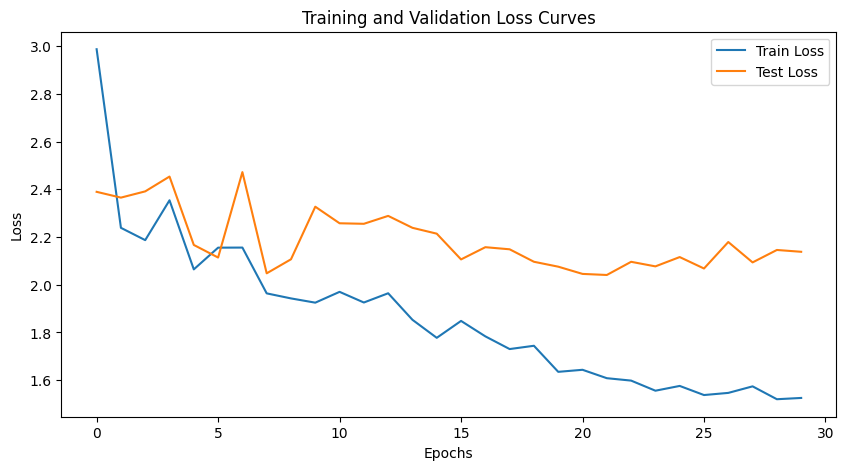

In [19]:
plot_training_curves(history)

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.79it/s]


Test mAP@0.5: 0.1414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


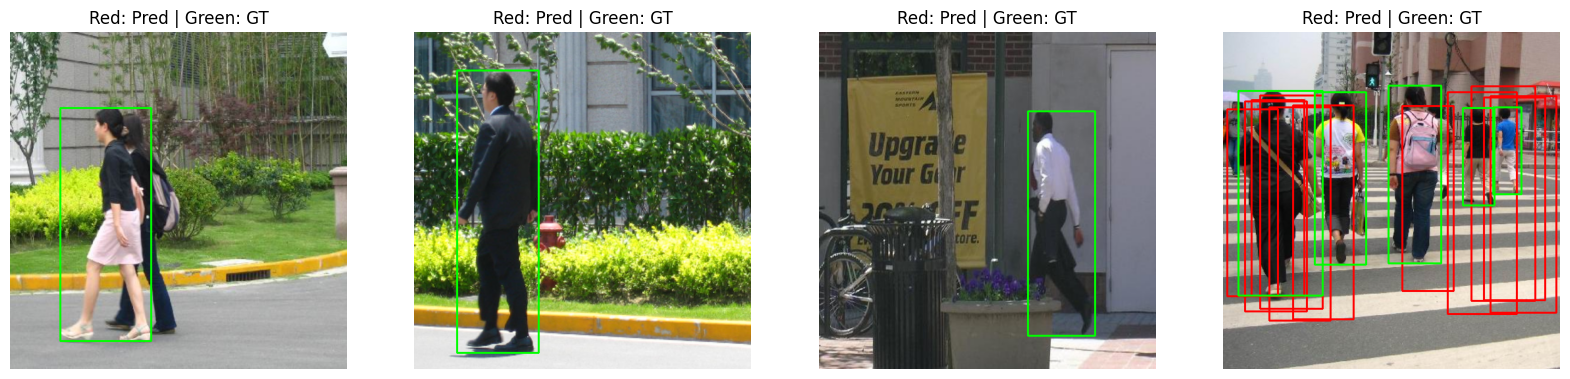

In [20]:
loaded_model = load_model("model_non_augment_base.pth")
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    val_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")
visualize_results(loaded_model, test_loader, device, threshold=0.5)


Test mAP@0.5: 0.1414 is very low

In [18]:
# Now augmented
trainset=PedestrianDataset(train_data,imagepaths,labelpaths,mode="train",jit=True,flip=True)
valset = PedestrianDataset(val_data,imagepaths,labelpaths,mode="val")
testset = PedestrianDataset(test_data,imagepaths,labelpaths,mode="val")
BATCH_SIZE = 8


train_loader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE*2, 
    shuffle=True, 
    pin_memory=True,
    collate_fn=collate_fn  
)

val_loader = DataLoader(
    valset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    collate_fn=collate_fn  
)

test_loader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn  
)

In [19]:
model_1 = DETR().to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')

print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_augment_base.pth")
        print("✓ Saved best model")

print("Training Complete.")

c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\kod\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2336800451.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is de

Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=3.14]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 3.2522 | Val Loss: 2.5612
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=1.81]


Epoch 2/30 | Train Loss: 2.3992 | Val Loss: 2.2449
✓ Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=1.72]


Epoch 3/30 | Train Loss: 2.1239 | Val Loss: 2.2470


Epoch 4 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=2.13]


Epoch 4/30 | Train Loss: 2.1262 | Val Loss: 2.0911
✓ Saved best model


Epoch 5 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.81it/s, loss=1.98]


Epoch 5/30 | Train Loss: 2.0990 | Val Loss: 2.3019


Epoch 6 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=2.14]


Epoch 6/30 | Train Loss: 1.9922 | Val Loss: 2.2736


Epoch 7 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.82it/s, loss=1.93]


Epoch 7/30 | Train Loss: 2.0164 | Val Loss: 2.8950


Epoch 8 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.78it/s, loss=1.95]


Epoch 8/30 | Train Loss: 2.0277 | Val Loss: 2.1347


Epoch 9 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=2.57]


Epoch 9/30 | Train Loss: 2.0618 | Val Loss: 2.2462


Epoch 10 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.73it/s, loss=2.01]


Epoch 10/30 | Train Loss: 2.0758 | Val Loss: 2.2575


Epoch 11 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.45]


Epoch 11/30 | Train Loss: 1.9762 | Val Loss: 2.1635


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.37]


Epoch 12/30 | Train Loss: 1.9301 | Val Loss: 2.0157
✓ Saved best model


Epoch 13 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.81it/s, loss=1.89]


Epoch 13/30 | Train Loss: 1.8494 | Val Loss: 2.1543


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.64]


Epoch 14/30 | Train Loss: 1.8860 | Val Loss: 2.1387


Epoch 15 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=1.79]


Epoch 15/30 | Train Loss: 1.7955 | Val Loss: 2.1842


Epoch 16 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=2.61]


Epoch 16/30 | Train Loss: 1.8222 | Val Loss: 2.2248


Epoch 17 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.44it/s, loss=1.9] 


Epoch 17/30 | Train Loss: 1.8792 | Val Loss: 2.0100
✓ Saved best model


Epoch 18 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=1.89]


Epoch 18/30 | Train Loss: 1.8084 | Val Loss: 2.1759


Epoch 19 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.75it/s, loss=2]   


Epoch 19/30 | Train Loss: 1.8007 | Val Loss: 2.1505


Epoch 20 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=1.46]


Epoch 20/30 | Train Loss: 1.7601 | Val Loss: 2.1514


Epoch 21 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.75it/s, loss=1.56]


Epoch 21/30 | Train Loss: 1.7447 | Val Loss: 1.9524
✓ Saved best model


Epoch 22 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.76]


Epoch 22/30 | Train Loss: 1.7424 | Val Loss: 2.1058


Epoch 23 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=1.82]


Epoch 23/30 | Train Loss: 1.7807 | Val Loss: 1.9860


Epoch 24 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=1.69]


Epoch 24/30 | Train Loss: 1.7134 | Val Loss: 1.9801


Epoch 25 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=1.87]


Epoch 25/30 | Train Loss: 1.7073 | Val Loss: 2.1095


Epoch 26 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.73it/s, loss=1.5] 


Epoch 26/30 | Train Loss: 1.6942 | Val Loss: 1.9534


Epoch 27 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.61]


Epoch 27/30 | Train Loss: 1.7012 | Val Loss: 2.1270


Epoch 28 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=1.82]


Epoch 28/30 | Train Loss: 1.7167 | Val Loss: 1.9242
✓ Saved best model


Epoch 29 [Train]: 100%|██████████| 30/30 [00:16<00:00,  1.86it/s, loss=1.78]


Epoch 29/30 | Train Loss: 1.6697 | Val Loss: 2.0446


Epoch 30 [Train]: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, loss=1.36]


Epoch 30/30 | Train Loss: 1.6582 | Val Loss: 2.0228
Training Complete.


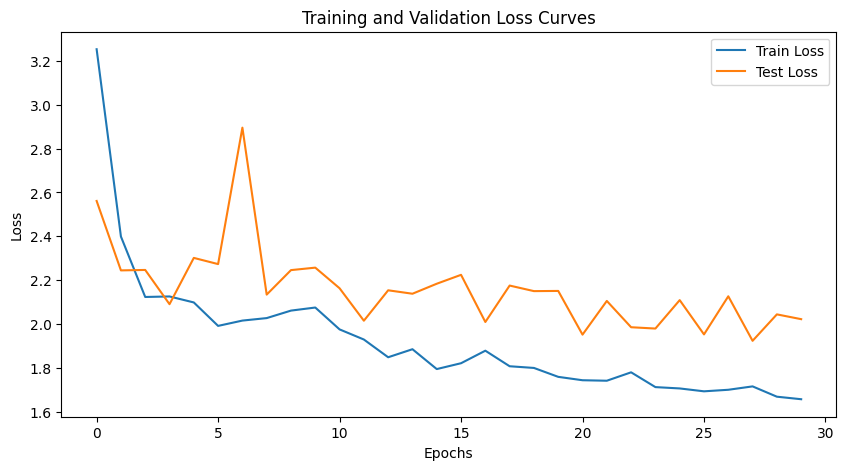

In [20]:
plot_training_curves(history)

Evaluating: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


Test mAP@0.5: 0.1468


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


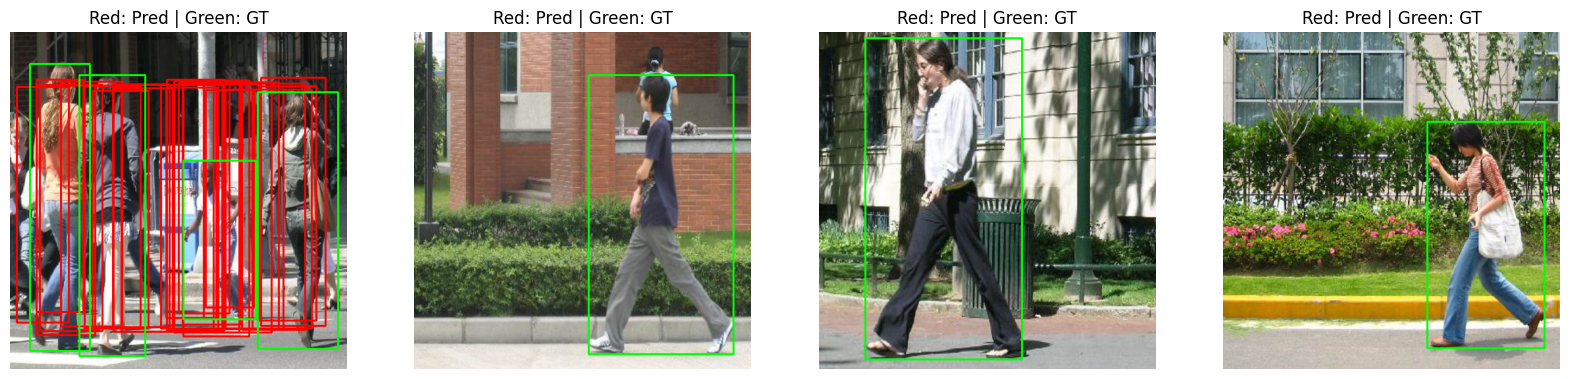

In [21]:
loaded_model = load_model("model_augment_base.pth")
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")
visualize_results(loaded_model, val_loader, device, threshold=0.5)


Got higher score so augmentation is better

In [22]:
model_1 = DETR(n_layers=4).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')

print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_2.pth")
        print("✓ Saved best model")

print("Training Complete.")

C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\53444694.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:19<00:00,  1.57it/s, loss=2.7] 
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 3.8497 | Val Loss: 2.8403
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.50it/s, loss=2.44]


Epoch 2/30 | Train Loss: 2.5436 | Val Loss: 2.6276
✓ Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s, loss=2.39]


Epoch 3/30 | Train Loss: 2.3936 | Val Loss: 2.0522
✓ Saved best model


Epoch 4 [Train]: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, loss=2.45]


Epoch 4/30 | Train Loss: 2.1085 | Val Loss: 2.1849


Epoch 5 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s, loss=3.18]


Epoch 5/30 | Train Loss: 2.2425 | Val Loss: 2.5207


Epoch 6 [Train]: 100%|██████████| 30/30 [00:18<00:00,  1.62it/s, loss=1.62]


Epoch 6/30 | Train Loss: 2.1144 | Val Loss: 2.4667


Epoch 7 [Train]: 100%|██████████| 30/30 [00:15<00:00,  1.98it/s, loss=1.76]


Epoch 7/30 | Train Loss: 2.0624 | Val Loss: 2.1651


Epoch 8 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.47it/s, loss=1.86]


Epoch 8/30 | Train Loss: 1.9480 | Val Loss: 2.6821


Epoch 9 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s, loss=1.66]


Epoch 9/30 | Train Loss: 2.0399 | Val Loss: 2.2390


Epoch 10 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.53it/s, loss=2.22]


Epoch 10/30 | Train Loss: 1.9491 | Val Loss: 2.0661


Epoch 11 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.50it/s, loss=2.07]


Epoch 11/30 | Train Loss: 1.9480 | Val Loss: 2.1775


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.52it/s, loss=1.8] 


Epoch 12/30 | Train Loss: 1.9928 | Val Loss: 2.3766


Epoch 13 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=1.82]


Epoch 13/30 | Train Loss: 1.9413 | Val Loss: 2.2505


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s, loss=2.26]


Epoch 14/30 | Train Loss: 1.9059 | Val Loss: 2.3614


Epoch 15 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s, loss=1.68]


Epoch 15/30 | Train Loss: 1.8152 | Val Loss: 2.1403


Epoch 16 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s, loss=2.06]


Epoch 16/30 | Train Loss: 1.7876 | Val Loss: 1.9824
✓ Saved best model


Epoch 17 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s, loss=1.56]


Epoch 17/30 | Train Loss: 1.7250 | Val Loss: 1.9631
✓ Saved best model


Epoch 18 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.53it/s, loss=1.9] 


Epoch 18/30 | Train Loss: 1.7498 | Val Loss: 2.0097


Epoch 19 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s, loss=1.3] 


Epoch 19/30 | Train Loss: 1.7463 | Val Loss: 2.1000


Epoch 20 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s, loss=1.49]


Epoch 20/30 | Train Loss: 1.7409 | Val Loss: 2.0247


Epoch 21 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s, loss=1.9] 


Epoch 21/30 | Train Loss: 1.7378 | Val Loss: 2.0089


Epoch 22 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s, loss=1.91]


Epoch 22/30 | Train Loss: 1.7251 | Val Loss: 1.9178
✓ Saved best model


Epoch 23 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=1.73]


Epoch 23/30 | Train Loss: 1.6776 | Val Loss: 1.8934
✓ Saved best model


Epoch 24 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s, loss=1.79]


Epoch 24/30 | Train Loss: 1.7213 | Val Loss: 1.9510


Epoch 25 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s, loss=1.88]


Epoch 25/30 | Train Loss: 1.6595 | Val Loss: 2.0819


Epoch 26 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s, loss=1.73]


Epoch 26/30 | Train Loss: 1.7169 | Val Loss: 2.0398


Epoch 27 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s, loss=1.42]


Epoch 27/30 | Train Loss: 1.6906 | Val Loss: 2.0975


Epoch 28 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.46it/s, loss=1.71]


Epoch 28/30 | Train Loss: 1.6989 | Val Loss: 1.9050


Epoch 29 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.53it/s, loss=1.56]


Epoch 29/30 | Train Loss: 1.6429 | Val Loss: 2.1016


Epoch 30 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s, loss=1.37]


Epoch 30/30 | Train Loss: 1.6760 | Val Loss: 2.0150
Training Complete.


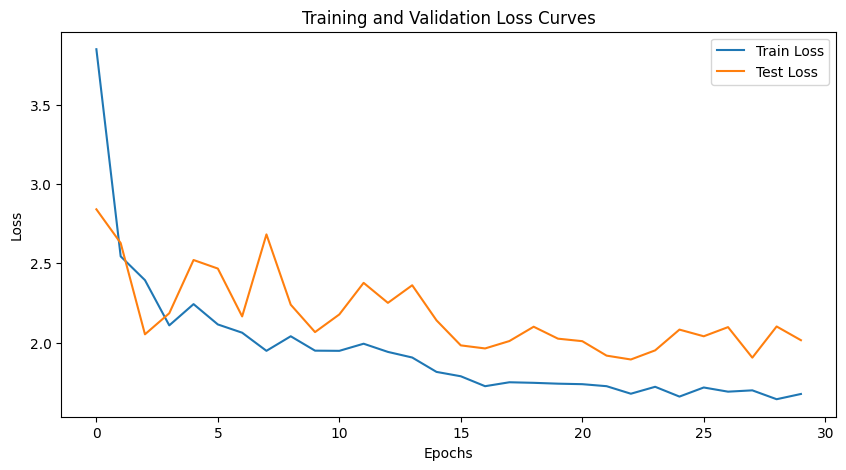

In [23]:
plot_training_curves(history)

In [24]:
loaded_model = load_model("model_2.pth",n_layers=4)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 15.42it/s]

Test mAP@0.5: 0.1638


N layers 4 got better results 

In [25]:
model_1 = DETR(n_queries=100).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')

print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_3.pth")
        print("✓ Saved best model")

print("Training Complete.")

C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\3281697014.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=2.1] 
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 2.7163 | Val Loss: 1.9697
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=2.31]


Epoch 2/30 | Train Loss: 2.1856 | Val Loss: 1.9059
✓ Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=2.25]


Epoch 3/30 | Train Loss: 1.8558 | Val Loss: 1.9989


Epoch 4 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s, loss=1.89]


Epoch 4/30 | Train Loss: 2.0205 | Val Loss: 2.1410


Epoch 5 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=1.88]


Epoch 5/30 | Train Loss: 1.8681 | Val Loss: 2.0589


Epoch 6 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=2.08]


Epoch 6/30 | Train Loss: 1.8549 | Val Loss: 2.3401


Epoch 7 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.85]


Epoch 7/30 | Train Loss: 1.9890 | Val Loss: 2.1756


Epoch 8 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.54]


Epoch 8/30 | Train Loss: 1.8093 | Val Loss: 1.7700
✓ Saved best model


Epoch 9 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=1.63]


Epoch 9/30 | Train Loss: 1.7356 | Val Loss: 1.8573


Epoch 10 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=1.88]


Epoch 10/30 | Train Loss: 1.6882 | Val Loss: 1.8126


Epoch 11 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=1.36]


Epoch 11/30 | Train Loss: 1.6860 | Val Loss: 1.8103


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=1.71]


Epoch 12/30 | Train Loss: 1.6547 | Val Loss: 1.7644
✓ Saved best model


Epoch 13 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s, loss=1.48]


Epoch 13/30 | Train Loss: 1.6090 | Val Loss: 1.6209
✓ Saved best model


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.73it/s, loss=1.51]


Epoch 14/30 | Train Loss: 1.5688 | Val Loss: 1.6617


Epoch 15 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=1.72]


Epoch 15/30 | Train Loss: 1.6187 | Val Loss: 1.6583


Epoch 16 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.46]


Epoch 16/30 | Train Loss: 1.6290 | Val Loss: 1.7259


Epoch 17 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=2.38]


Epoch 17/30 | Train Loss: 1.6895 | Val Loss: 1.9076


Epoch 18 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=1.8] 


Epoch 18/30 | Train Loss: 1.7542 | Val Loss: 1.9654


Epoch 19 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=1.5] 


Epoch 19/30 | Train Loss: 1.6566 | Val Loss: 1.7952


Epoch 20 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=1.71]


Epoch 20/30 | Train Loss: 1.5737 | Val Loss: 1.6381


Epoch 21 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.75it/s, loss=1.35]


Epoch 21/30 | Train Loss: 1.5414 | Val Loss: 1.8238


Epoch 22 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=1.65]


Epoch 22/30 | Train Loss: 1.5570 | Val Loss: 1.7039


Epoch 23 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.59]


Epoch 23/30 | Train Loss: 1.5180 | Val Loss: 1.7596


Epoch 24 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s, loss=1.18]


Epoch 24/30 | Train Loss: 1.4999 | Val Loss: 1.7942


Epoch 25 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=1.6] 


Epoch 25/30 | Train Loss: 1.5033 | Val Loss: 1.7461


Epoch 26 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=1.28]


Epoch 26/30 | Train Loss: 1.5460 | Val Loss: 1.7429


Epoch 27 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.77it/s, loss=1.39]


Epoch 27/30 | Train Loss: 1.4844 | Val Loss: 1.7570


Epoch 28 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=1.77]


Epoch 28/30 | Train Loss: 1.4713 | Val Loss: 1.7059


Epoch 29 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s, loss=1.17]


Epoch 29/30 | Train Loss: 1.4185 | Val Loss: 1.7416


Epoch 30 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s, loss=1.51]


Epoch 30/30 | Train Loss: 1.4911 | Val Loss: 1.7747
Training Complete.


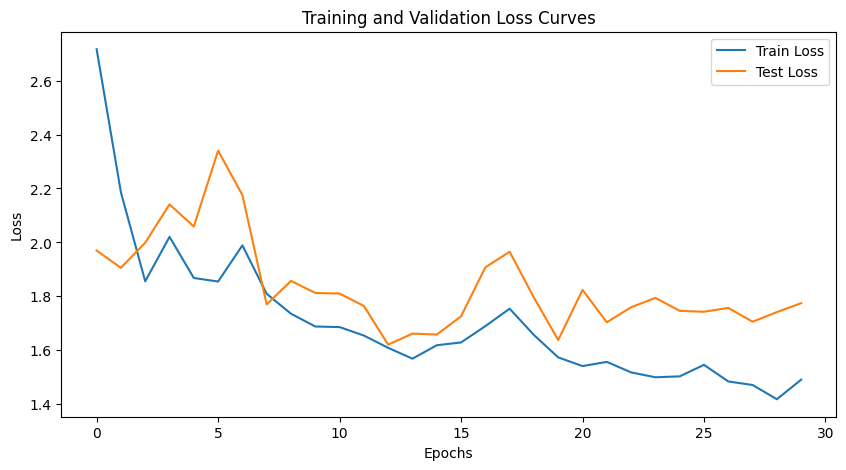

In [26]:
plot_training_curves(history)

In [27]:
loaded_model = load_model("model_3.pth",n_queries=100)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 15.60it/s]

Test mAP@0.5: 0.0447


N _queries 100 got low score so lower count might be better.

In [28]:
model_1 = DETR(n_queries=20).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')

print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_4.pth")
        print("✓ Saved best model")

print("Training Complete.")

C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\185417156.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s, loss=3.13]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 3.5417 | Val Loss: 2.8379
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s, loss=2.27]


Epoch 2/30 | Train Loss: 2.6182 | Val Loss: 2.7066
✓ Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.15]


Epoch 3/30 | Train Loss: 2.4391 | Val Loss: 2.3569
✓ Saved best model


Epoch 4 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=2.08]


Epoch 4/30 | Train Loss: 2.4516 | Val Loss: 2.2966
✓ Saved best model


Epoch 5 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=2.63]


Epoch 5/30 | Train Loss: 2.2689 | Val Loss: 2.3023


Epoch 6 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.73it/s, loss=1.93]


Epoch 6/30 | Train Loss: 2.1460 | Val Loss: 2.3591


Epoch 7 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=2.09]


Epoch 7/30 | Train Loss: 2.3541 | Val Loss: 2.5300


Epoch 8 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s, loss=2.38]


Epoch 8/30 | Train Loss: 2.2175 | Val Loss: 2.5181


Epoch 9 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=1.99]


Epoch 9/30 | Train Loss: 2.2858 | Val Loss: 2.3467


Epoch 10 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=2.23]


Epoch 10/30 | Train Loss: 2.1420 | Val Loss: 2.4512


Epoch 11 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.75it/s, loss=1.81]


Epoch 11/30 | Train Loss: 2.1499 | Val Loss: 2.1877
✓ Saved best model


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.73it/s, loss=2.58]


Epoch 12/30 | Train Loss: 2.0834 | Val Loss: 2.2743


Epoch 13 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.76it/s, loss=2.06]


Epoch 13/30 | Train Loss: 2.0637 | Val Loss: 2.3401


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=2.12]


Epoch 14/30 | Train Loss: 2.0272 | Val Loss: 2.1879


Epoch 15 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=1.99]


Epoch 15/30 | Train Loss: 2.0268 | Val Loss: 2.3449


Epoch 16 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=2.06]


Epoch 16/30 | Train Loss: 1.9399 | Val Loss: 2.3346


Epoch 17 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=2.01]


Epoch 17/30 | Train Loss: 1.9136 | Val Loss: 2.2781


Epoch 18 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=2.06]


Epoch 18/30 | Train Loss: 1.8946 | Val Loss: 2.2853


Epoch 19 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=2.16]


Epoch 19/30 | Train Loss: 1.9087 | Val Loss: 2.1116
✓ Saved best model


Epoch 20 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.74it/s, loss=1.82]


Epoch 20/30 | Train Loss: 1.8848 | Val Loss: 2.2506


Epoch 21 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=1.87]


Epoch 21/30 | Train Loss: 1.8380 | Val Loss: 2.2168


Epoch 22 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.78it/s, loss=1.97]


Epoch 22/30 | Train Loss: 1.8854 | Val Loss: 2.2334


Epoch 23 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s, loss=1.76]


Epoch 23/30 | Train Loss: 1.7814 | Val Loss: 2.0651
✓ Saved best model


Epoch 24 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=1.74]


Epoch 24/30 | Train Loss: 1.7639 | Val Loss: 2.3027


Epoch 25 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.79it/s, loss=1.65]


Epoch 25/30 | Train Loss: 1.7450 | Val Loss: 2.2987


Epoch 26 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=1.6] 


Epoch 26/30 | Train Loss: 1.7092 | Val Loss: 2.2102


Epoch 27 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=1.53]


Epoch 27/30 | Train Loss: 1.6261 | Val Loss: 2.1834


Epoch 28 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.76it/s, loss=1.73]


Epoch 28/30 | Train Loss: 1.6195 | Val Loss: 2.1386


Epoch 29 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s, loss=1.63]


Epoch 29/30 | Train Loss: 1.5865 | Val Loss: 2.0591
✓ Saved best model


Epoch 30 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=2.04]


Epoch 30/30 | Train Loss: 1.6010 | Val Loss: 2.0695
Training Complete.


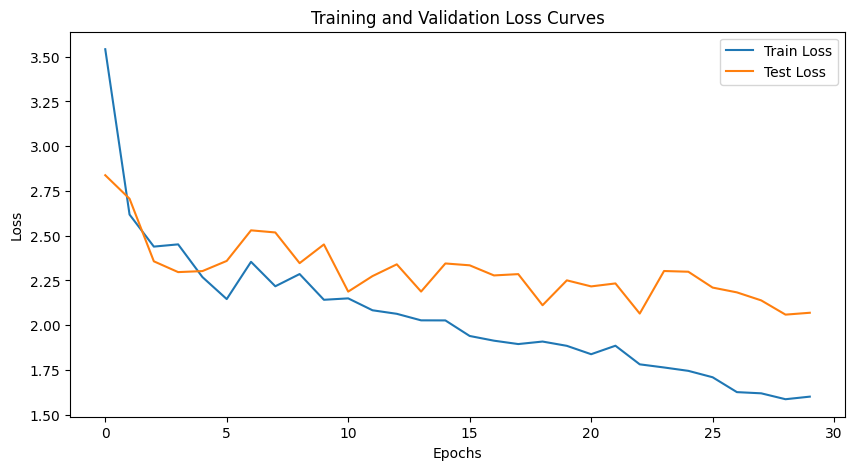

In [29]:
plot_training_curves(history)

In [30]:
loaded_model = load_model("model_4.pth",n_queries=20)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 15.60it/s]

Test mAP@0.5: 0.3970


queries 20 got 0.39 a significant jump so this is important

In [31]:
model_1 = DETR(n_heads=4).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')

print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_5.pth")
        print("✓ Saved best model")

print("Training Complete.")

C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\4213453294.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.74it/s, loss=2.32]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 3.1222 | Val Loss: 2.5612
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=2.25]


Epoch 2/30 | Train Loss: 2.4367 | Val Loss: 2.3490
✓ Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.76it/s, loss=1.9] 


Epoch 3/30 | Train Loss: 2.3047 | Val Loss: 2.2920
✓ Saved best model


Epoch 4 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=1.79]


Epoch 4/30 | Train Loss: 2.2276 | Val Loss: 2.5882


Epoch 5 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=2.18]


Epoch 5/30 | Train Loss: 2.1050 | Val Loss: 2.1637
✓ Saved best model


Epoch 6 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=1.58]


Epoch 6/30 | Train Loss: 2.1581 | Val Loss: 2.1571
✓ Saved best model


Epoch 7 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=1.97]


Epoch 7/30 | Train Loss: 2.0061 | Val Loss: 2.2839


Epoch 8 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=2.09]


Epoch 8/30 | Train Loss: 2.0087 | Val Loss: 2.1475
✓ Saved best model


Epoch 9 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s, loss=2.03]


Epoch 9/30 | Train Loss: 1.9068 | Val Loss: 2.0127
✓ Saved best model


Epoch 10 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.77it/s, loss=1.86]


Epoch 10/30 | Train Loss: 1.8973 | Val Loss: 2.4347


Epoch 11 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s, loss=1.81]


Epoch 11/30 | Train Loss: 1.8954 | Val Loss: 2.3590


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=2.04]


Epoch 12/30 | Train Loss: 1.9725 | Val Loss: 2.0842


Epoch 13 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=1.67]


Epoch 13/30 | Train Loss: 1.8260 | Val Loss: 2.0534


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=2.1] 


Epoch 14/30 | Train Loss: 1.8375 | Val Loss: 2.0721


Epoch 15 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.64]


Epoch 15/30 | Train Loss: 1.8347 | Val Loss: 2.0677


Epoch 16 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.13]


Epoch 16/30 | Train Loss: 1.8287 | Val Loss: 2.1662


Epoch 17 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s, loss=1.88]


Epoch 17/30 | Train Loss: 1.8864 | Val Loss: 2.0251


Epoch 18 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=1.62]


Epoch 18/30 | Train Loss: 1.8149 | Val Loss: 2.0885


Epoch 19 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.93]


Epoch 19/30 | Train Loss: 1.7594 | Val Loss: 2.0380


Epoch 20 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=1.88]


Epoch 20/30 | Train Loss: 1.7856 | Val Loss: 2.1436


Epoch 21 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=1.46]


Epoch 21/30 | Train Loss: 1.6702 | Val Loss: 1.8732
✓ Saved best model


Epoch 22 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=1.92]


Epoch 22/30 | Train Loss: 1.6603 | Val Loss: 1.9848


Epoch 23 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=2.1] 


Epoch 23/30 | Train Loss: 1.6964 | Val Loss: 1.9842


Epoch 24 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=1.81]


Epoch 24/30 | Train Loss: 1.6432 | Val Loss: 1.9818


Epoch 25 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.68]


Epoch 25/30 | Train Loss: 1.6331 | Val Loss: 2.0381


Epoch 26 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.52]


Epoch 26/30 | Train Loss: 1.6095 | Val Loss: 1.9224


Epoch 27 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=1.67]


Epoch 27/30 | Train Loss: 1.5916 | Val Loss: 2.0233


Epoch 28 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.77it/s, loss=1.54]


Epoch 28/30 | Train Loss: 1.6294 | Val Loss: 1.8580
✓ Saved best model


Epoch 29 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=1.58]


Epoch 29/30 | Train Loss: 1.5614 | Val Loss: 2.0498


Epoch 30 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=1.53]


Epoch 30/30 | Train Loss: 1.5702 | Val Loss: 2.0084
Training Complete.


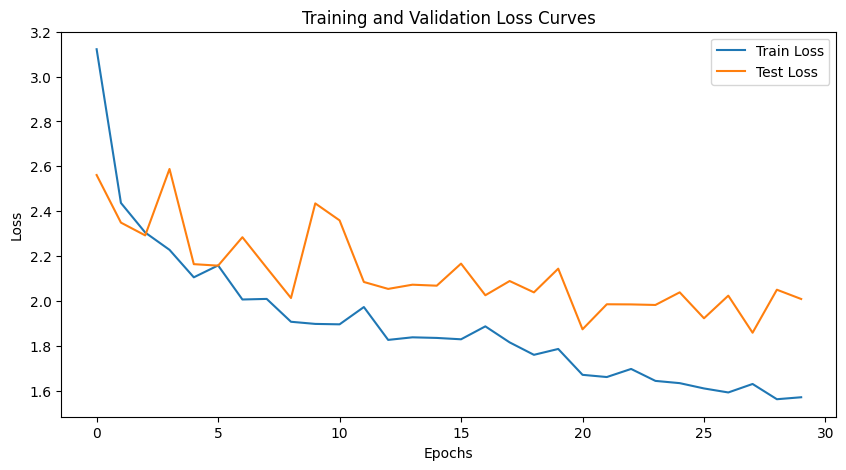

In [32]:
plot_training_curves(history)

In [33]:
loaded_model=load_model("model_5.pth",n_heads=4)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 15.42it/s]

Test mAP@0.5: 0.0616


n_heads 4 got ok result might be worse or better 

In [34]:
model_1 = DETR(n_queries=15).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')

print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_6.pth")
        print("✓ Saved best model")

print("Training Complete.")

C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2849010945.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.73it/s, loss=3.56]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 3.7602 | Val Loss: 2.8947
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.79it/s, loss=2.79]


Epoch 2/30 | Train Loss: 2.7096 | Val Loss: 3.0387


Epoch 3 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=2.26]


Epoch 3/30 | Train Loss: 2.5573 | Val Loss: 2.7073
✓ Saved best model


Epoch 4 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.51]


Epoch 4/30 | Train Loss: 2.3698 | Val Loss: 2.5379
✓ Saved best model


Epoch 5 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.23]


Epoch 5/30 | Train Loss: 2.3086 | Val Loss: 2.6883


Epoch 6 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s, loss=2.46]


Epoch 6/30 | Train Loss: 2.3227 | Val Loss: 2.5547


Epoch 7 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=1.85]


Epoch 7/30 | Train Loss: 2.3330 | Val Loss: 2.3669
✓ Saved best model


Epoch 8 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=2.34]


Epoch 8/30 | Train Loss: 2.1279 | Val Loss: 2.6003


Epoch 9 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=2.06]


Epoch 9/30 | Train Loss: 2.2017 | Val Loss: 2.3874


Epoch 10 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s, loss=2.26]


Epoch 10/30 | Train Loss: 2.1371 | Val Loss: 2.5117


Epoch 11 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s, loss=2.26]


Epoch 11/30 | Train Loss: 2.1270 | Val Loss: 2.4053


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=2.13]


Epoch 12/30 | Train Loss: 2.0884 | Val Loss: 2.3946


Epoch 13 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.19]


Epoch 13/30 | Train Loss: 2.0515 | Val Loss: 2.3635
✓ Saved best model


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=2.24]


Epoch 14/30 | Train Loss: 2.0495 | Val Loss: 2.2163
✓ Saved best model


Epoch 15 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.76it/s, loss=1.93]


Epoch 15/30 | Train Loss: 1.9871 | Val Loss: 2.3399


Epoch 16 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s, loss=1.87]


Epoch 16/30 | Train Loss: 1.9761 | Val Loss: 2.3160


Epoch 17 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=2.37]


Epoch 17/30 | Train Loss: 1.9616 | Val Loss: 2.3631


Epoch 18 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=2.14]


Epoch 18/30 | Train Loss: 1.9295 | Val Loss: 2.3417


Epoch 19 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=2.03]


Epoch 19/30 | Train Loss: 1.9318 | Val Loss: 2.3050


Epoch 20 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s, loss=2.12]


Epoch 20/30 | Train Loss: 1.8563 | Val Loss: 2.3452


Epoch 21 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=1.86]


Epoch 21/30 | Train Loss: 1.8427 | Val Loss: 2.2945


Epoch 22 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.85]


Epoch 22/30 | Train Loss: 1.7867 | Val Loss: 2.4710


Epoch 23 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.75]


Epoch 23/30 | Train Loss: 1.8516 | Val Loss: 2.1680
✓ Saved best model


Epoch 24 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=1.75]


Epoch 24/30 | Train Loss: 1.8049 | Val Loss: 2.2629


Epoch 25 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=1.54]


Epoch 25/30 | Train Loss: 1.7360 | Val Loss: 2.2662


Epoch 26 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=1.74]


Epoch 26/30 | Train Loss: 1.6855 | Val Loss: 2.1148
✓ Saved best model


Epoch 27 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=1.6] 


Epoch 27/30 | Train Loss: 1.6275 | Val Loss: 2.1376


Epoch 28 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.74it/s, loss=1.73]


Epoch 28/30 | Train Loss: 1.5495 | Val Loss: 2.2329


Epoch 29 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=1.72]


Epoch 29/30 | Train Loss: 1.5681 | Val Loss: 2.1651


Epoch 30 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=1.52]


Epoch 30/30 | Train Loss: 1.5800 | Val Loss: 2.0109
✓ Saved best model
Training Complete.


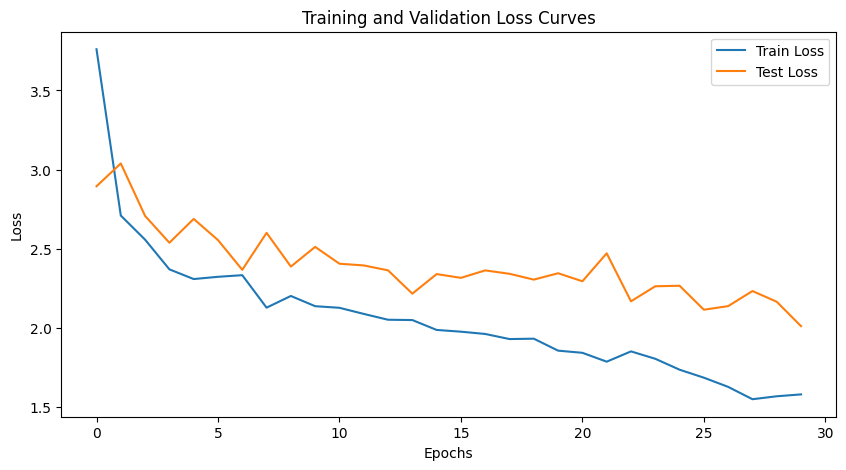

In [35]:
plot_training_curves(history)

In [36]:
loaded_model=load_model("model_6.pth",n_queries=15)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s]

Test mAP@0.5: 0.4314


queries 15 got higher score i will keep 15 for the rest.

In [ ]:
model_1 = DETR(backbone_name="v2").to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')

print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_7.pth")
        print("✓ Saved best model")

print("Training Complete.")

c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2349082018.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s, loss=2.21]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 3.2813 | Val Loss: 2.4334
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s, loss=2.11]


Epoch 2/30 | Train Loss: 2.2751 | Val Loss: 2.1343
✓ Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s, loss=2.33]


Epoch 3/30 | Train Loss: 2.1965 | Val Loss: 2.0942
✓ Saved best model


Epoch 4 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.52it/s, loss=1.74]


Epoch 4/30 | Train Loss: 2.0902 | Val Loss: 2.0622
✓ Saved best model


Epoch 5 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s, loss=1.92]


Epoch 5/30 | Train Loss: 2.0483 | Val Loss: 2.0961


Epoch 6 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s, loss=2.05]


Epoch 6/30 | Train Loss: 2.0636 | Val Loss: 2.2009


Epoch 7 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=2.07]


Epoch 7/30 | Train Loss: 1.9661 | Val Loss: 2.1602


Epoch 8 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s, loss=1.84]


Epoch 8/30 | Train Loss: 1.9862 | Val Loss: 2.0987


Epoch 9 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s, loss=2.07]


Epoch 9/30 | Train Loss: 1.9648 | Val Loss: 2.2836


Epoch 10 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=2.23]


Epoch 10/30 | Train Loss: 2.0631 | Val Loss: 2.3061


Epoch 11 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=1.89]


Epoch 11/30 | Train Loss: 1.9345 | Val Loss: 2.1736


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s, loss=2.07]


Epoch 12/30 | Train Loss: 1.8718 | Val Loss: 1.9376
✓ Saved best model


Epoch 13 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.53it/s, loss=1.86]


Epoch 13/30 | Train Loss: 1.8009 | Val Loss: 2.0926


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s, loss=1.64]


Epoch 14/30 | Train Loss: 1.8166 | Val Loss: 2.0711


Epoch 15 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s, loss=2.25]


Epoch 15/30 | Train Loss: 1.9833 | Val Loss: 2.4506


Epoch 16 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s, loss=1.93]


Epoch 16/30 | Train Loss: 2.0172 | Val Loss: 2.1903


Epoch 17 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s, loss=1.69]


Epoch 17/30 | Train Loss: 1.9138 | Val Loss: 1.9800


Epoch 18 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=2.06]


Epoch 18/30 | Train Loss: 2.0163 | Val Loss: 2.3304


Epoch 19 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.61]


Epoch 19/30 | Train Loss: 1.8966 | Val Loss: 1.9370
✓ Saved best model


Epoch 20 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.44]


Epoch 20/30 | Train Loss: 1.8016 | Val Loss: 1.9516


Epoch 21 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=1.96]


Epoch 21/30 | Train Loss: 1.8132 | Val Loss: 2.1187


Epoch 22 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s, loss=1.67]


Epoch 22/30 | Train Loss: 1.8406 | Val Loss: 2.0540


Epoch 23 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=1.66]


Epoch 23/30 | Train Loss: 1.7339 | Val Loss: 1.8846
✓ Saved best model


Epoch 24 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=1.81]


Epoch 24/30 | Train Loss: 1.7337 | Val Loss: 2.0366


Epoch 25 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s, loss=1.65]


Epoch 25/30 | Train Loss: 1.7693 | Val Loss: 2.0755


Epoch 26 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.50it/s, loss=1.88]


Epoch 26/30 | Train Loss: 1.7550 | Val Loss: 2.2379


Epoch 27 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s, loss=1.74]


Epoch 27/30 | Train Loss: 1.8070 | Val Loss: 1.9841


Epoch 28 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.06it/s, loss=1.8] 


Epoch 28/30 | Train Loss: 1.7581 | Val Loss: 2.1298


Epoch 29 [Train]: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, loss=1.83]


Epoch 29/30 | Train Loss: 1.7451 | Val Loss: 2.0275


Epoch 30 [Train]: 100%|██████████| 30/30 [00:13<00:00,  2.20it/s, loss=1.85]


Epoch 30/30 | Train Loss: 1.7377 | Val Loss: 2.0288
Training Complete.


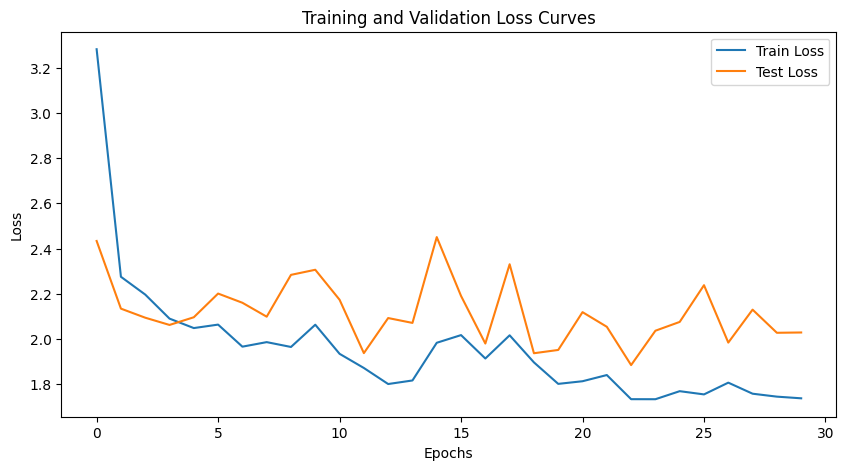

In [38]:
plot_training_curves(history)

In [ ]:
loaded_model=load_model("model_7.pth",backbone_name="v2")
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]

Test mAP@0.5: 0.1104


v2 didnt get any improvemnet over resnet but might still be tested.

In [ ]:
model_1 = DETR(backbone_name="v2",n_queries=15).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')

print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_8.pth")
        print("✓ Saved best model")

print("Training Complete.")

C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\3741905094.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s, loss=3.1] 
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 3.5898 | Val Loss: 2.9510
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.08it/s, loss=3.16]


Epoch 2/30 | Train Loss: 2.8403 | Val Loss: 2.6261
✓ Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:17<00:00,  1.76it/s, loss=2.78]


Epoch 3/30 | Train Loss: 2.5168 | Val Loss: 2.4200
✓ Saved best model


Epoch 4 [Train]: 100%|██████████| 30/30 [00:15<00:00,  1.92it/s, loss=2.38]


Epoch 4/30 | Train Loss: 2.4817 | Val Loss: 2.5870


Epoch 5 [Train]: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, loss=2.3] 


Epoch 5/30 | Train Loss: 2.3359 | Val Loss: 2.3714
✓ Saved best model


Epoch 6 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.12it/s, loss=1.99]


Epoch 6/30 | Train Loss: 2.3581 | Val Loss: 2.4271


Epoch 7 [Train]: 100%|██████████| 30/30 [00:18<00:00,  1.59it/s, loss=2.3] 


Epoch 7/30 | Train Loss: 2.2644 | Val Loss: 2.5938


Epoch 8 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s, loss=2.16]


Epoch 8/30 | Train Loss: 2.2508 | Val Loss: 2.5856


Epoch 9 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s, loss=2.11]


Epoch 9/30 | Train Loss: 2.2816 | Val Loss: 2.6679


Epoch 10 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.02it/s, loss=2.41]


Epoch 10/30 | Train Loss: 2.2488 | Val Loss: 2.4929


Epoch 11 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s, loss=1.78]


Epoch 11/30 | Train Loss: 2.2169 | Val Loss: 2.1786
✓ Saved best model


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.52it/s, loss=1.98]


Epoch 12/30 | Train Loss: 2.1143 | Val Loss: 2.3469


Epoch 13 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.50it/s, loss=2.12]


Epoch 13/30 | Train Loss: 2.1133 | Val Loss: 2.2978


Epoch 14 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=2.5] 


Epoch 14/30 | Train Loss: 2.1084 | Val Loss: 2.3420


Epoch 15 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.52it/s, loss=2.21]


Epoch 15/30 | Train Loss: 2.0575 | Val Loss: 2.3380


Epoch 16 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.53it/s, loss=2.13]


Epoch 16/30 | Train Loss: 2.0835 | Val Loss: 2.3249


Epoch 17 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=1.77]


Epoch 17/30 | Train Loss: 1.9954 | Val Loss: 2.3023


Epoch 18 [Train]: 100%|██████████| 30/30 [00:17<00:00,  1.76it/s, loss=2.45]


Epoch 18/30 | Train Loss: 1.9541 | Val Loss: 2.1611
✓ Saved best model


Epoch 19 [Train]: 100%|██████████| 30/30 [00:21<00:00,  1.41it/s, loss=2.64]


Epoch 19/30 | Train Loss: 2.1217 | Val Loss: 2.5208


Epoch 20 [Train]: 100%|██████████| 30/30 [00:18<00:00,  1.64it/s, loss=2.35]


Epoch 20/30 | Train Loss: 2.0061 | Val Loss: 2.3660


Epoch 21 [Train]: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s, loss=1.71]


Epoch 21/30 | Train Loss: 1.9128 | Val Loss: 2.3799


Epoch 22 [Train]: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s, loss=1.97]


Epoch 22/30 | Train Loss: 1.8671 | Val Loss: 2.3153


Epoch 23 [Train]: 100%|██████████| 30/30 [00:20<00:00,  1.46it/s, loss=1.78]


Epoch 23/30 | Train Loss: 1.8270 | Val Loss: 2.0226
✓ Saved best model


Epoch 24 [Train]: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s, loss=1.78]


Epoch 24/30 | Train Loss: 1.8243 | Val Loss: 2.1113


Epoch 25 [Train]: 100%|██████████| 30/30 [00:20<00:00,  1.45it/s, loss=1.66]


Epoch 25/30 | Train Loss: 1.8091 | Val Loss: 2.1024


Epoch 26 [Train]: 100%|██████████| 30/30 [00:16<00:00,  1.86it/s, loss=1.95]


Epoch 26/30 | Train Loss: 1.7433 | Val Loss: 2.0727


Epoch 27 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.52it/s, loss=1.91]


Epoch 27/30 | Train Loss: 1.7511 | Val Loss: 2.1040


Epoch 28 [Train]:  23%|██▎       | 7/30 [00:03<00:10,  2.12it/s, loss=1.63]


KeyboardInterrupt: 

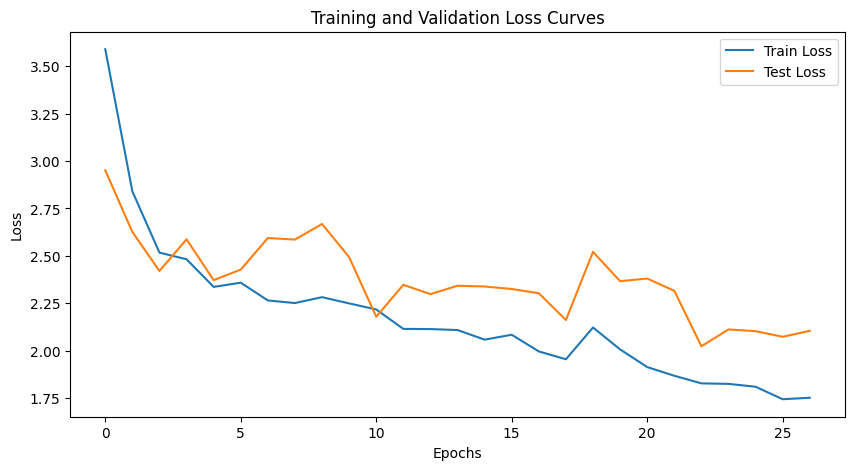

In [41]:
plot_training_curves(history)

In [ ]:
loaded_model=load_model("model_8.pth",backbone_name="v2",n_queries=15)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]

Test mAP@0.5: 0.3550


With v2 and queries 0.35 it got lower so i need to change some things. And go back to resnet 15 query.

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
losses = ['labels', 'boxes']

matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)

criterion = SetCriterion(num_classes=1, matcher=matcher, weight_dict=weight_dict, eos_coef=0.2, losses=losses)
criterion = criterion.to(device)

Now i will change the eos coef for comparison

In [46]:
model_1 = DETR(backbone_name="resnet",n_queries=15).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')
early_stop=0
print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_9.pth")
        print("✓ Saved best model")
        early_stop=0
    else:
        early_stop+=1
        if early_stop>10:
            print("Early stopping triggered.")
            break

print("Training Complete.")

C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2648328656.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=3.21]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 3.7017 | Val Loss: 2.7521
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.53]


Epoch 2/30 | Train Loss: 2.6605 | Val Loss: 2.6572
✓ Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s, loss=2.19]


Epoch 3/30 | Train Loss: 2.3876 | Val Loss: 2.5273
✓ Saved best model


Epoch 4 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.06it/s, loss=2.19]


Epoch 4/30 | Train Loss: 2.3900 | Val Loss: 2.6112


Epoch 5 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.01it/s, loss=2.7] 


Epoch 5/30 | Train Loss: 2.5052 | Val Loss: 3.3270


Epoch 6 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.01it/s, loss=2.18]


Epoch 6/30 | Train Loss: 2.4670 | Val Loss: 2.3451
✓ Saved best model


Epoch 7 [Train]: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s, loss=2.3] 


Epoch 7/30 | Train Loss: 2.3165 | Val Loss: 2.5289


Epoch 8 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.40it/s, loss=2.24]


Epoch 8/30 | Train Loss: 2.2913 | Val Loss: 2.5496


Epoch 9 [Train]: 100%|██████████| 30/30 [00:19<00:00,  1.58it/s, loss=2.35]


Epoch 9/30 | Train Loss: 2.2966 | Val Loss: 2.7059


Epoch 10 [Train]: 100%|██████████| 30/30 [00:13<00:00,  2.26it/s, loss=2.48]


Epoch 10/30 | Train Loss: 2.1796 | Val Loss: 2.5846


Epoch 11 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.42it/s, loss=2.35]


Epoch 11/30 | Train Loss: 2.1249 | Val Loss: 2.6278


Epoch 12 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.45it/s, loss=2.26]


Epoch 12/30 | Train Loss: 2.1415 | Val Loss: 2.6528


Epoch 13 [Train]: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s, loss=2.01]


Epoch 13/30 | Train Loss: 2.1426 | Val Loss: 2.3122
✓ Saved best model


Epoch 14 [Train]: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s, loss=2.23]


Epoch 14/30 | Train Loss: 2.1111 | Val Loss: 2.4372


Epoch 15 [Train]: 100%|██████████| 30/30 [00:17<00:00,  1.76it/s, loss=2.01]


Epoch 15/30 | Train Loss: 2.0946 | Val Loss: 2.4328


Epoch 16 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.00it/s, loss=1.91]


Epoch 16/30 | Train Loss: 2.0606 | Val Loss: 2.5488


Epoch 17 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.71]


Epoch 17/30 | Train Loss: 2.0078 | Val Loss: 2.4164


Epoch 18 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.06it/s, loss=1.88]


Epoch 18/30 | Train Loss: 1.9492 | Val Loss: 2.6118


Epoch 19 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s, loss=2.05]


Epoch 19/30 | Train Loss: 1.9051 | Val Loss: 2.2753
✓ Saved best model


Epoch 20 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=2.16]


Epoch 20/30 | Train Loss: 1.9349 | Val Loss: 2.3455


Epoch 21 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s, loss=1.91]


Epoch 21/30 | Train Loss: 1.9110 | Val Loss: 2.3259


Epoch 22 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s, loss=2.09]


Epoch 22/30 | Train Loss: 1.9068 | Val Loss: 2.4577


Epoch 23 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=1.75]


Epoch 23/30 | Train Loss: 1.8564 | Val Loss: 2.3082


Epoch 24 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=2.23]


Epoch 24/30 | Train Loss: 1.8147 | Val Loss: 2.3139


Epoch 25 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.8] 


Epoch 25/30 | Train Loss: 1.7966 | Val Loss: 2.1750
✓ Saved best model


Epoch 26 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=1.96]


Epoch 26/30 | Train Loss: 1.6936 | Val Loss: 2.1645
✓ Saved best model


Epoch 27 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s, loss=1.61]


Epoch 27/30 | Train Loss: 1.7344 | Val Loss: 2.1821


Epoch 28 [Train]: 100%|██████████| 30/30 [00:16<00:00,  1.84it/s, loss=1.74]


Epoch 28/30 | Train Loss: 1.6224 | Val Loss: 2.2680


Epoch 29 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=1.55]


Epoch 29/30 | Train Loss: 1.5884 | Val Loss: 2.2131


Epoch 30 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=1.29]


Epoch 30/30 | Train Loss: 1.5779 | Val Loss: 2.2526
Training Complete.


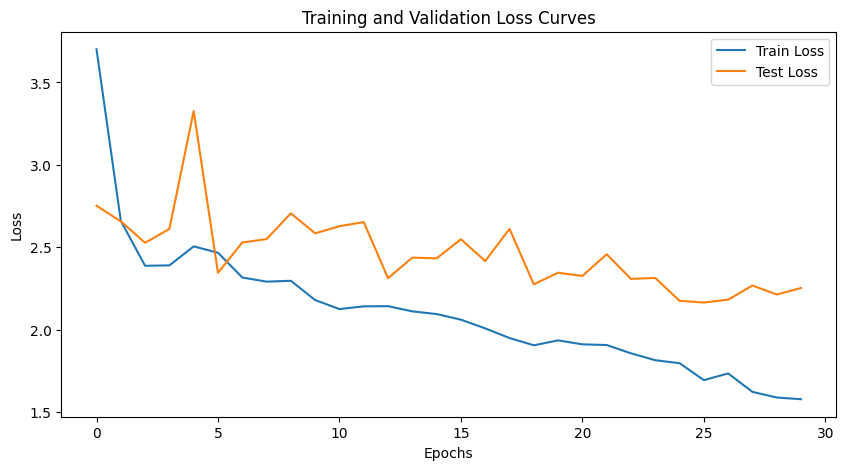

In [47]:
plot_training_curves(history)

Evaluating: 100%|██████████| 4/4 [00:00<00:00,  8.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Test mAP@0.5: 0.4468


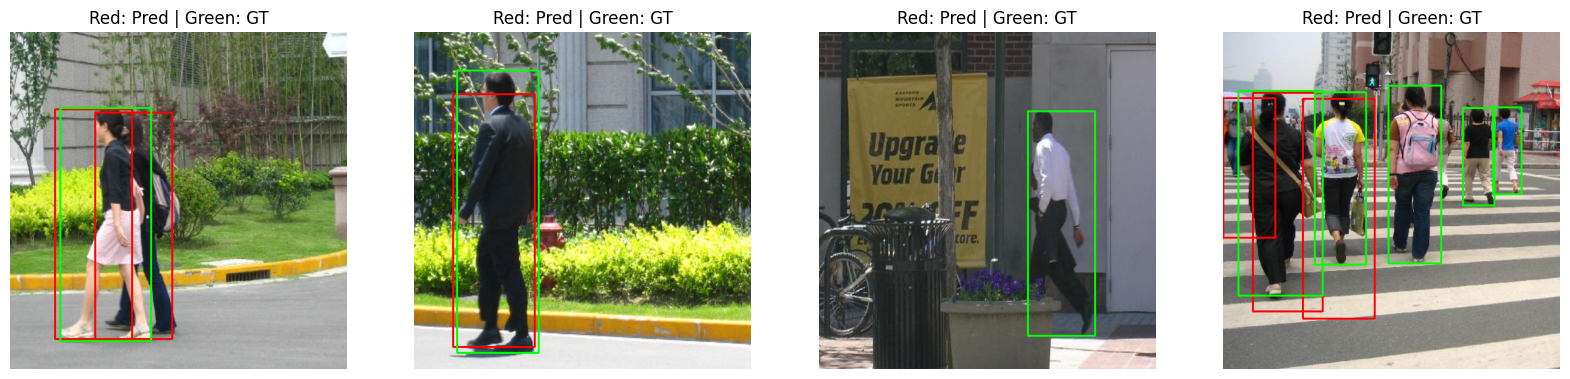

In [48]:
loaded_model=load_model("model_9.pth",backbone_name="resnet",n_queries=15)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")
visualize_results(loaded_model, test_loader, device, threshold=0.5)

eos coef of 0.2 is a bit better so it is now used

In [49]:
model_1 = DETR(backbone_name="resnet",n_queries=15,n_heads=4).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')
early_stop=0
print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_10.pth")
        print("✓ Saved best model")
        early_stop=0
    else:
        early_stop+=1
        if early_stop>10:
            print("Early stopping triggered.")
            break

print("Training Complete.")

c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\kod\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\4201215202.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is de

Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=2.67]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 3.4051 | Val Loss: 2.8008
✓ Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.75it/s, loss=2.19]


Epoch 2/30 | Train Loss: 2.6312 | Val Loss: 2.3906
✓ Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.14it/s, loss=3.05]


Epoch 3/30 | Train Loss: 2.5471 | Val Loss: 2.7460


Epoch 4 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=2.17]


Epoch 4/30 | Train Loss: 2.4904 | Val Loss: 2.3763
✓ Saved best model


Epoch 5 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.23]


Epoch 5/30 | Train Loss: 2.4609 | Val Loss: 2.5631


Epoch 6 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=2.03]


Epoch 6/30 | Train Loss: 2.3517 | Val Loss: 2.5809


Epoch 7 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.22]


Epoch 7/30 | Train Loss: 2.3472 | Val Loss: 2.5394


Epoch 8 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=2.17]


Epoch 8/30 | Train Loss: 2.3131 | Val Loss: 2.5997


Epoch 9 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=2.16]


Epoch 9/30 | Train Loss: 2.2931 | Val Loss: 2.5642


Epoch 10 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s, loss=2.16]


Epoch 10/30 | Train Loss: 2.2260 | Val Loss: 2.3811


Epoch 11 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=1.87]


Epoch 11/30 | Train Loss: 2.1908 | Val Loss: 2.5507


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=2.57]


Epoch 12/30 | Train Loss: 2.1731 | Val Loss: 2.6851


Epoch 13 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s, loss=2.38]


Epoch 13/30 | Train Loss: 2.2051 | Val Loss: 2.3602
✓ Saved best model


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.98]


Epoch 14/30 | Train Loss: 2.0318 | Val Loss: 2.3750


Epoch 15 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=1.98]


Epoch 15/30 | Train Loss: 2.0124 | Val Loss: 2.4220


Epoch 16 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=2.22]


Epoch 16/30 | Train Loss: 1.9742 | Val Loss: 2.4365


Epoch 17 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, loss=2.53]


Epoch 17/30 | Train Loss: 2.0615 | Val Loss: 2.5544


Epoch 18 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=1.93]


Epoch 18/30 | Train Loss: 1.9638 | Val Loss: 2.4282


Epoch 19 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=1.9] 


Epoch 19/30 | Train Loss: 1.8683 | Val Loss: 2.2823
✓ Saved best model


Epoch 20 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=1.94]


Epoch 20/30 | Train Loss: 1.7833 | Val Loss: 2.2538
✓ Saved best model


Epoch 21 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s, loss=1.62]


Epoch 21/30 | Train Loss: 1.7821 | Val Loss: 2.2946


Epoch 22 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s, loss=1.8] 


Epoch 22/30 | Train Loss: 1.8002 | Val Loss: 2.2418
✓ Saved best model


Epoch 23 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s, loss=1.64]


Epoch 23/30 | Train Loss: 1.7045 | Val Loss: 2.2245
✓ Saved best model


Epoch 24 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=1.59]


Epoch 24/30 | Train Loss: 1.6263 | Val Loss: 2.1060
✓ Saved best model


Epoch 25 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.76it/s, loss=1.73]


Epoch 25/30 | Train Loss: 1.5785 | Val Loss: 2.1470


Epoch 26 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.76it/s, loss=1.61]


Epoch 26/30 | Train Loss: 1.5959 | Val Loss: 2.1423


Epoch 27 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.76it/s, loss=1.7] 


Epoch 27/30 | Train Loss: 1.5723 | Val Loss: 2.2048


Epoch 28 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.73it/s, loss=1.81]


Epoch 28/30 | Train Loss: 1.5640 | Val Loss: 1.9836
✓ Saved best model


Epoch 29 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=1.74]


Epoch 29/30 | Train Loss: 1.5246 | Val Loss: 2.0836


Epoch 30 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.76it/s, loss=1.5] 


Epoch 30/30 | Train Loss: 1.5729 | Val Loss: 2.1065
Training Complete.


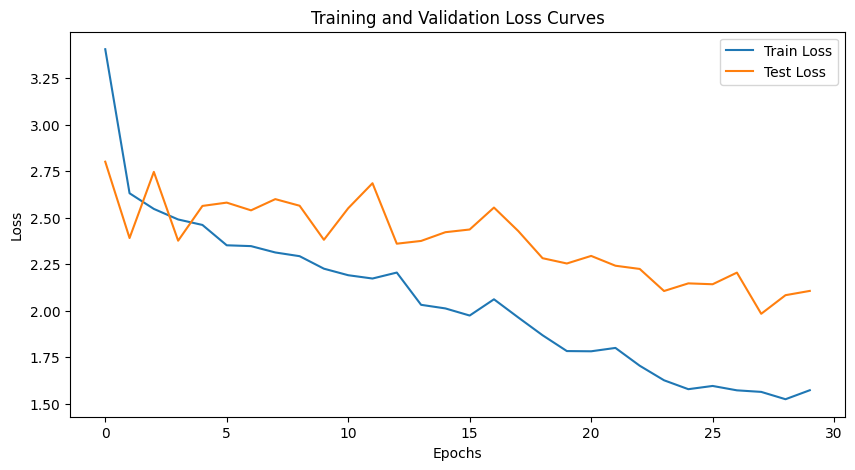

In [50]:
plot_training_curves(history)

In [51]:
loaded_model=load_model("model_10.pth",backbone_name="resnet",n_queries=15,n_heads=4)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s]

Test mAP@0.5: 0.5451


0.54 is best socre so far and less attention heads work better

In [53]:
model_1 = DETR(backbone_name="resnet",n_queries=15,n_heads=16).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 150
best_loss = float('inf')
early_stop=0
print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_11.pth")
        print("Saved best model")
        early_stop=0
    else:
        early_stop+=1
        if early_stop>10:
            print("Early stopping triggered.")
            break

print("Training Complete.")

C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\1498748292.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s, loss=3.08]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/150 | Train Loss: 3.5697 | Val Loss: 2.7810
Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=2.31]


Epoch 2/150 | Train Loss: 2.6550 | Val Loss: 2.7070
Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.48]


Epoch 3/150 | Train Loss: 2.4857 | Val Loss: 2.5063
Saved best model


Epoch 4 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=2.75]


Epoch 4/150 | Train Loss: 2.4089 | Val Loss: 2.5465


Epoch 5 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s, loss=2.17]


Epoch 5/150 | Train Loss: 2.3215 | Val Loss: 2.5912


Epoch 6 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=2.3] 


Epoch 6/150 | Train Loss: 2.3339 | Val Loss: 2.5465


Epoch 7 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=2.1] 


Epoch 7/150 | Train Loss: 2.2154 | Val Loss: 2.3709
Saved best model


Epoch 8 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=2.08]


Epoch 8/150 | Train Loss: 2.2612 | Val Loss: 2.5465


Epoch 9 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.73it/s, loss=2.13]


Epoch 9/150 | Train Loss: 2.2328 | Val Loss: 2.4979


Epoch 10 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s, loss=2.08]


Epoch 10/150 | Train Loss: 2.1823 | Val Loss: 2.5749


Epoch 11 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s, loss=2.14]


Epoch 11/150 | Train Loss: 2.2596 | Val Loss: 2.5775


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=2.57]


Epoch 12/150 | Train Loss: 2.2454 | Val Loss: 2.4595


Epoch 13 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=1.99]


Epoch 13/150 | Train Loss: 2.1547 | Val Loss: 2.5828


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=2.87]


Epoch 14/150 | Train Loss: 2.1880 | Val Loss: 2.6117


Epoch 15 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=2.28]


Epoch 15/150 | Train Loss: 2.1484 | Val Loss: 2.5553


Epoch 16 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.83]


Epoch 16/150 | Train Loss: 2.0564 | Val Loss: 2.4743


Epoch 17 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=2.42]


Epoch 17/150 | Train Loss: 2.0021 | Val Loss: 2.4573


Epoch 18 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=2.12]


Epoch 18/150 | Train Loss: 2.0440 | Val Loss: 2.4509
Early stopping triggered.
Training Complete.


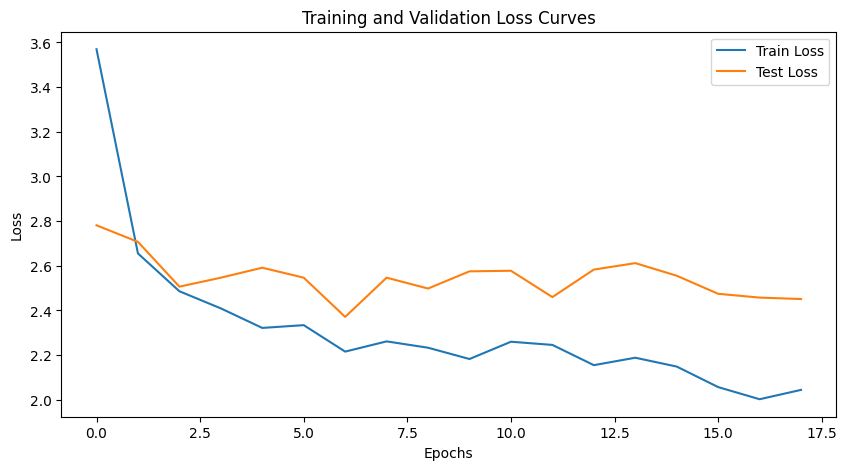

In [54]:
plot_training_curves(history)

In [58]:
loaded_model=load_model("model_11.pth",backbone_name="resnet",n_queries=15,n_heads=16)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")

c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\kod\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Evaluating: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

Test mAP@0.5: 0.2399


a drastic decrese from 0.54 4 heads is best

In [59]:
model_1 = DETR(backbone_name="resnet",n_queries=15,n_layers=1,n_heads=4).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 150
best_loss = float('inf')
early_stop=0
print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_12.pth")
        print("Saved best model")
        early_stop=0
    else:
        early_stop+=1
        if early_stop>10:
            print("Early stopping triggered.")
            break

print("Training Complete.")

C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\4179320145.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, loss=2.55]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/150 | Train Loss: 3.3053 | Val Loss: 2.7696
Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.75it/s, loss=2.7] 


Epoch 2/150 | Train Loss: 2.5897 | Val Loss: 2.6946
Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=2.24]


Epoch 3/150 | Train Loss: 2.5003 | Val Loss: 2.6028
Saved best model


Epoch 4 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=2.38]


Epoch 4/150 | Train Loss: 2.4427 | Val Loss: 2.5664
Saved best model


Epoch 5 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.75it/s, loss=2.13]


Epoch 5/150 | Train Loss: 2.3225 | Val Loss: 2.3207
Saved best model


Epoch 6 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.73it/s, loss=2.53]


Epoch 6/150 | Train Loss: 2.2748 | Val Loss: 2.7449


Epoch 7 [Train]: 100%|██████████| 30/30 [00:10<00:00,  2.74it/s, loss=2.03]


Epoch 7/150 | Train Loss: 2.2753 | Val Loss: 2.4377


Epoch 8 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s, loss=2.42]


Epoch 8/150 | Train Loss: 2.2764 | Val Loss: 2.7880


Epoch 9 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, loss=1.98]


Epoch 9/150 | Train Loss: 2.2513 | Val Loss: 2.4786


Epoch 10 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, loss=2.12]


Epoch 10/150 | Train Loss: 2.1139 | Val Loss: 2.6657


Epoch 11 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=2.23]


Epoch 11/150 | Train Loss: 2.0758 | Val Loss: 2.4910


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, loss=1.95]


Epoch 12/150 | Train Loss: 2.0953 | Val Loss: 2.8084


Epoch 13 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s, loss=2.08]


Epoch 13/150 | Train Loss: 2.0730 | Val Loss: 2.6487


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s, loss=1.84]


Epoch 14/150 | Train Loss: 2.0687 | Val Loss: 2.4555


Epoch 15 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, loss=1.78]


Epoch 15/150 | Train Loss: 2.0471 | Val Loss: 2.4299


Epoch 16 [Train]: 100%|██████████| 30/30 [00:15<00:00,  1.90it/s, loss=1.94]


Epoch 16/150 | Train Loss: 1.9814 | Val Loss: 2.6694
Early stopping triggered.
Training Complete.


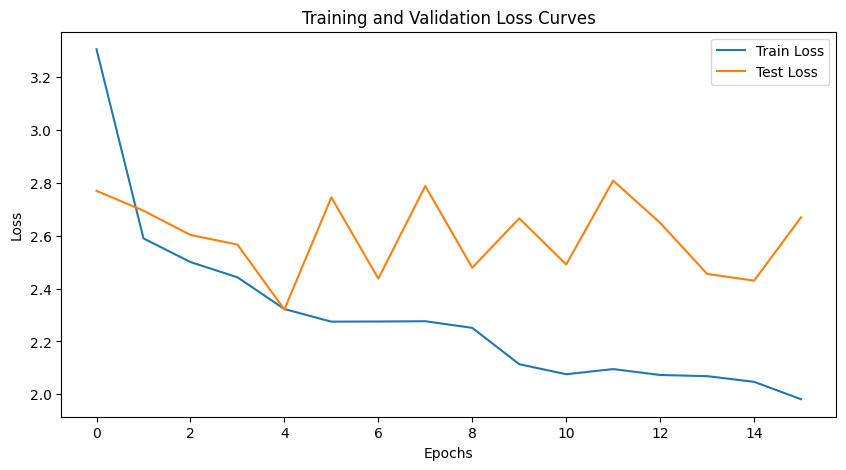

In [60]:
plot_training_curves(history)

In [61]:
loaded_model=load_model("model_12.pth",backbone_name="resnet",n_queries=15,n_layers=1,n_heads=4)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")

Evaluating: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s]

Test mAP@0.5: 0.2749


In [62]:
model_1 = DETR(backbone_name="resnet",n_queries=15,n_layers=3,n_heads=4).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 150
best_loss = float('inf')
early_stop=0
print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_13.pth")
        print("Saved best model")
        early_stop=0
    else:
        early_stop+=1
        if early_stop>10:
            print("Early stopping triggered.")
            break

print("Training Complete.")

C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\147292966.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:15<00:00,  1.89it/s, loss=2.42]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/150 | Train Loss: 3.7797 | Val Loss: 3.1819
Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s, loss=2.38]


Epoch 2/150 | Train Loss: 2.7452 | Val Loss: 2.6091
Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s, loss=2.37]


Epoch 3/150 | Train Loss: 2.5235 | Val Loss: 2.7446


Epoch 4 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s, loss=2.49]


Epoch 4/150 | Train Loss: 2.5349 | Val Loss: 2.6771


Epoch 5 [Train]: 100%|██████████| 30/30 [00:16<00:00,  1.83it/s, loss=2.15]


Epoch 5/150 | Train Loss: 2.4334 | Val Loss: 2.7382


Epoch 6 [Train]: 100%|██████████| 30/30 [00:14<00:00,  2.14it/s, loss=1.94]


Epoch 6/150 | Train Loss: 2.3622 | Val Loss: 2.5905
Saved best model


Epoch 7 [Train]: 100%|██████████| 30/30 [00:15<00:00,  1.98it/s, loss=2.79]


Epoch 7/150 | Train Loss: 2.3101 | Val Loss: 2.3457
Saved best model


Epoch 8 [Train]: 100%|██████████| 30/30 [00:20<00:00,  1.48it/s, loss=2.92]


Epoch 8/150 | Train Loss: 2.4037 | Val Loss: 2.7368


Epoch 9 [Train]: 100%|██████████| 30/30 [00:20<00:00,  1.46it/s, loss=1.86]


Epoch 9/150 | Train Loss: 2.3778 | Val Loss: 2.6147


Epoch 10 [Train]: 100%|██████████| 30/30 [00:18<00:00,  1.61it/s, loss=2.23]


Epoch 10/150 | Train Loss: 2.2800 | Val Loss: 2.7433


Epoch 11 [Train]: 100%|██████████| 30/30 [00:13<00:00,  2.17it/s, loss=2.71]


Epoch 11/150 | Train Loss: 2.2610 | Val Loss: 2.4565


Epoch 12 [Train]: 100%|██████████| 30/30 [00:15<00:00,  1.90it/s, loss=1.87]


Epoch 12/150 | Train Loss: 2.1677 | Val Loss: 2.6363


Epoch 13 [Train]: 100%|██████████| 30/30 [00:16<00:00,  1.84it/s, loss=2.06]


Epoch 13/150 | Train Loss: 2.1213 | Val Loss: 2.4441


Epoch 14 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.50it/s, loss=2.37]


Epoch 14/150 | Train Loss: 2.0796 | Val Loss: 2.4134


Epoch 15 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=2.03]


Epoch 15/150 | Train Loss: 2.1158 | Val Loss: 2.5672


Epoch 16 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.50it/s, loss=1.94]


Epoch 16/150 | Train Loss: 2.1900 | Val Loss: 2.4348


Epoch 17 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.46it/s, loss=2.22]


Epoch 17/150 | Train Loss: 2.0419 | Val Loss: 2.6109


Epoch 18 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=2.06]


Epoch 18/150 | Train Loss: 2.1606 | Val Loss: 2.3148
Saved best model


Epoch 19 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=2.93]


Epoch 19/150 | Train Loss: 2.0688 | Val Loss: 2.5331


Epoch 20 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s, loss=2.11]


Epoch 20/150 | Train Loss: 2.0729 | Val Loss: 2.4692


Epoch 21 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s, loss=2.18]


Epoch 21/150 | Train Loss: 2.0236 | Val Loss: 2.2750
Saved best model


Epoch 22 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s, loss=1.96]


Epoch 22/150 | Train Loss: 2.0487 | Val Loss: 2.3287


Epoch 23 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s, loss=1.93]


Epoch 23/150 | Train Loss: 1.9361 | Val Loss: 2.4000


Epoch 24 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s, loss=1.89]


Epoch 24/150 | Train Loss: 1.8739 | Val Loss: 2.3696


Epoch 25 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s, loss=2.01]


Epoch 25/150 | Train Loss: 1.9039 | Val Loss: 2.2239
Saved best model


Epoch 26 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s, loss=1.76]


Epoch 26/150 | Train Loss: 1.9228 | Val Loss: 2.3142


Epoch 27 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s, loss=1.99]


Epoch 27/150 | Train Loss: 1.9651 | Val Loss: 2.5032


Epoch 28 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s, loss=2.11]


Epoch 28/150 | Train Loss: 1.8520 | Val Loss: 2.3731


Epoch 29 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s, loss=1.66]


Epoch 29/150 | Train Loss: 1.8318 | Val Loss: 2.1615
Saved best model


Epoch 30 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s, loss=1.91]


Epoch 30/150 | Train Loss: 1.9181 | Val Loss: 2.4493


Epoch 31 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s, loss=1.66]


Epoch 31/150 | Train Loss: 1.7041 | Val Loss: 2.1266
Saved best model


Epoch 32 [Train]:   3%|▎         | 1/30 [00:00<00:13,  2.14it/s, loss=1.67]


KeyboardInterrupt: 

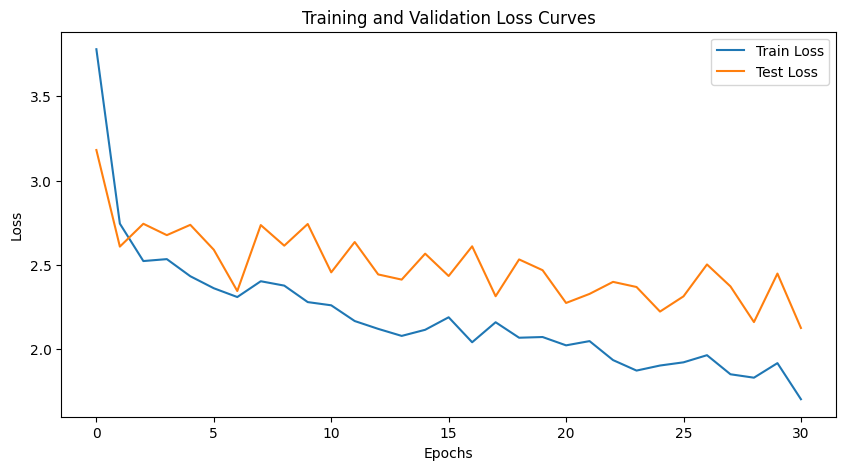

In [63]:
plot_training_curves(history)

In [65]:
loaded_model=load_model("model_13.pth",backbone_name="resnet",n_queries=15,n_layers=3,n_heads=4)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")

Evaluating: 100%|██████████| 4/4 [00:00<00:00,  9.19it/s]

Test mAP@0.5: 0.4829


Now to test the best model structure wtih the V2 net after that the as last test

In [ ]:
model_1 = DETR(backbone_name="v2",n_queries=15,n_heads=4).to(device)

optimizer = optim.AdamW(params=model_1.parameters(),lr=0.0001, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
# Change patience to 10 or 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

EPOCHS = 30
best_loss = float('inf')
early_stop=0
print("Starting Simplified Training...")
history=[]
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model_1, train_loader, optimizer, epoch, scaler)
    
    # Validate
    val_loss = validate(model_1, val_loader)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    history.append([train_loss, val_loss])
    
    # Save the current best model for evaluation for later
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model_1.state_dict(), "model_14.pth")
        print("Saved best model")
        early_stop=0
    else:
        early_stop+=1
        if early_stop>10:
            print("Early stopping triggered.")
            break

print("Training Complete.")


C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2193357673.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Simplified Training...


Epoch 1 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=2.62]
C:\Users\deniz\AppData\Local\Temp\ipykernel_12428\2207953230.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 3.6083 | Val Loss: 3.1629
Saved best model


Epoch 2 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.50it/s, loss=2.7] 


Epoch 2/30 | Train Loss: 2.6906 | Val Loss: 2.6127
Saved best model


Epoch 3 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.50it/s, loss=2.33]


Epoch 3/30 | Train Loss: 2.5474 | Val Loss: 2.6303


Epoch 4 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=2.45]


Epoch 4/30 | Train Loss: 2.5334 | Val Loss: 3.0098


Epoch 5 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s, loss=2.28]


Epoch 5/30 | Train Loss: 2.4195 | Val Loss: 2.6993


Epoch 6 [Train]: 100%|██████████| 30/30 [00:21<00:00,  1.40it/s, loss=2.71]


Epoch 6/30 | Train Loss: 2.3197 | Val Loss: 2.3646
Saved best model


Epoch 7 [Train]: 100%|██████████| 30/30 [00:15<00:00,  1.90it/s, loss=2.43]


Epoch 7/30 | Train Loss: 2.3370 | Val Loss: 2.5327


Epoch 8 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.46it/s, loss=2.58]


Epoch 8/30 | Train Loss: 2.2913 | Val Loss: 2.5653


Epoch 9 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s, loss=1.92]


Epoch 9/30 | Train Loss: 2.2823 | Val Loss: 2.5116


Epoch 10 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.45it/s, loss=2.6] 


Epoch 10/30 | Train Loss: 2.3286 | Val Loss: 2.7607


Epoch 11 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=2.12]


Epoch 11/30 | Train Loss: 2.2517 | Val Loss: 2.7874


Epoch 12 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.51it/s, loss=1.97]


Epoch 12/30 | Train Loss: 2.2157 | Val Loss: 2.4424


Epoch 13 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.53it/s, loss=2.09]


Epoch 13/30 | Train Loss: 2.2696 | Val Loss: 2.3932


Epoch 14 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s, loss=1.95]


Epoch 14/30 | Train Loss: 2.1389 | Val Loss: 2.3289
Saved best model


Epoch 15 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s, loss=1.92]


Epoch 15/30 | Train Loss: 2.1319 | Val Loss: 2.3372


Epoch 16 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=1.64]


Epoch 16/30 | Train Loss: 2.0252 | Val Loss: 2.2552
Saved best model


Epoch 17 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.47it/s, loss=2.02]


Epoch 17/30 | Train Loss: 1.9756 | Val Loss: 2.3244


Epoch 18 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.50it/s, loss=1.77]


Epoch 18/30 | Train Loss: 1.9242 | Val Loss: 2.5640


Epoch 19 [Train]: 100%|██████████| 30/30 [00:11<00:00,  2.50it/s, loss=1.8] 


Epoch 19/30 | Train Loss: 1.9725 | Val Loss: 2.2652


Epoch 20 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.46it/s, loss=2.29]


Epoch 20/30 | Train Loss: 1.8914 | Val Loss: 2.2464
Saved best model


Epoch 21 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=1.56]


Epoch 21/30 | Train Loss: 1.7929 | Val Loss: 2.1779
Saved best model


Epoch 22 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=1.91]


Epoch 22/30 | Train Loss: 1.7896 | Val Loss: 2.1117
Saved best model


Epoch 23 [Train]: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s, loss=1.56]


Epoch 23/30 | Train Loss: 1.7530 | Val Loss: 2.1968


Epoch 24 [Train]: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s, loss=1.71]


Epoch 24/30 | Train Loss: 1.7884 | Val Loss: 2.2666


Epoch 25 [Train]: 100%|██████████| 30/30 [00:21<00:00,  1.42it/s, loss=1.88]


Epoch 25/30 | Train Loss: 1.7055 | Val Loss: 2.1711


Epoch 26 [Train]: 100%|██████████| 30/30 [00:21<00:00,  1.43it/s, loss=1.79]


Epoch 26/30 | Train Loss: 1.7680 | Val Loss: 2.2003


Epoch 27 [Train]: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s, loss=1.55]


Epoch 27/30 | Train Loss: 1.6295 | Val Loss: 2.2566


Epoch 28 [Train]: 100%|██████████| 30/30 [00:16<00:00,  1.80it/s, loss=1.56]


Epoch 28/30 | Train Loss: 1.5523 | Val Loss: 2.2314


Epoch 29 [Train]: 100%|██████████| 30/30 [00:17<00:00,  1.74it/s, loss=1.47]


Epoch 29/30 | Train Loss: 1.6267 | Val Loss: 2.1426


Epoch 30 [Train]: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s, loss=1.59]


Epoch 30/30 | Train Loss: 1.5180 | Val Loss: 2.0839
Saved best model
Training Complete.


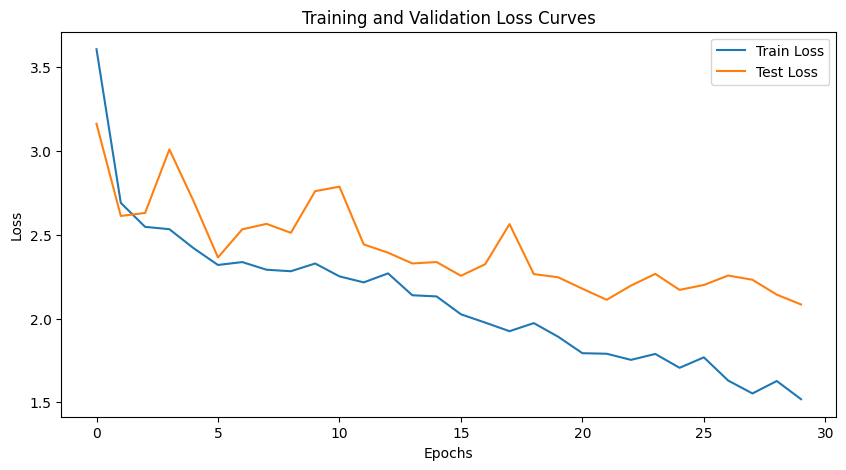

In [77]:
plot_training_curves(history)

Evaluating: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


Test mAP@0.5: 0.5035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


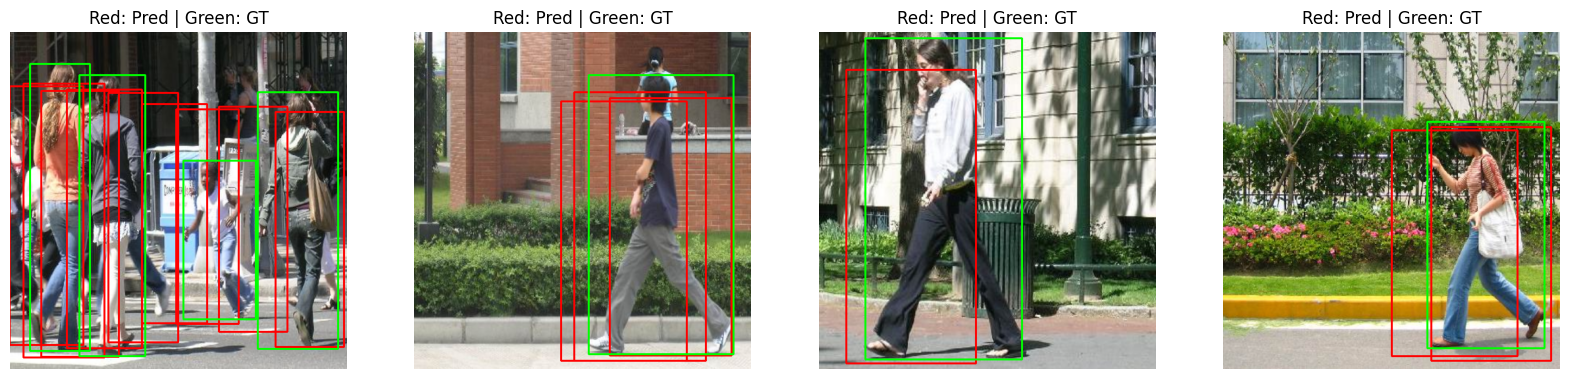

In [ ]:
loaded_model=load_model("model_14.pth",backbone_name="v2",n_queries=15,n_heads=4)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")
visualize_results(loaded_model, val_loader, device, threshold=0.5)


c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\kod\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\kod\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Evaluating: 100%|██████████| 4/4 [00:00<00:00,  9.10it/s]
Clipping input data to the valid range for imshow with RGB data ([

Test mAP@0.5: 0.5451


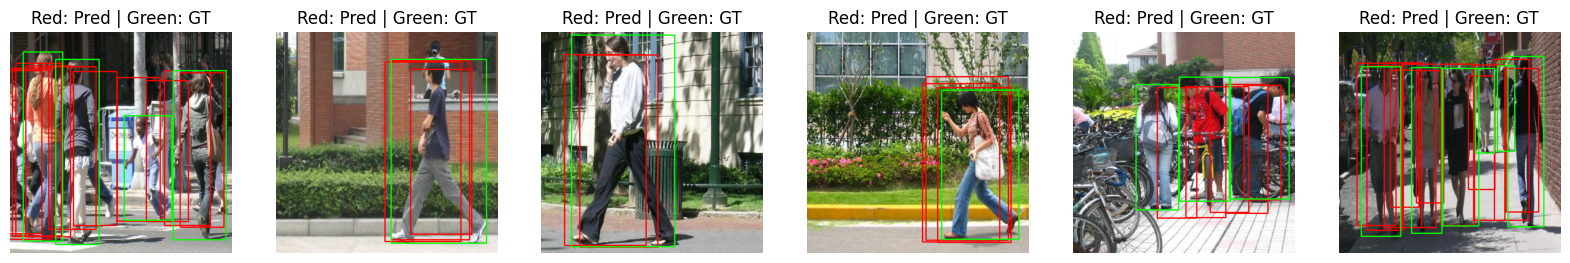

In [80]:
loaded_model=load_model("model_10.pth",backbone_name="resnet",n_queries=15,n_heads=4)
pred_boxes_xyxy, gt_boxes_xyxy = evaluate_and_get_predictions(
    loaded_model, 
    test_loader, 
    device, 
    threshold=0.5 
)

map_score = compute_map(pred_boxes_xyxy, gt_boxes_xyxy)

print(f"Test mAP@0.5: {map_score:.4f}")
visualize_results(loaded_model, val_loader, device, threshold=0.5,n_images=6)

